# Water quality data analysis pipeline

## Version and History

This notebook was created by Hannah Greenwald to analyze water quality, flow cytometry, and qPCR data related to a corresponding publication on drinking water stagnation in building plumbing on campus buildings during the COVID-19 pandemic. This notebook was created with assistance from Dr. Lauren Kennedy.

Anyone seeking to use this code will need to change the directories and place files in the proper directory with the data.

# Set up notebook

In [193]:
# install.packages("httpuv")
# install.packages("ggpubr")
# install.packages("lubridate")
# install.packages("Hmisc")
# install.packages("GGally")
# install.packages("googlesheets4")
# install.packages("httpuv")
# install.packages("googledrive")
# install.packages("dplyr")
# install.packages("readr")
# install.packages("readxl")
# install.packages("ggtext")
# install.packages("devtools")


In [194]:
library("googlesheets4")
library("googledrive")
library('httpuv')
library('ggplot2')
library('scales')
library('repr')
library('tidyr')
library('readr')
library('dplyr')
library('viridis')
library('ggpubr')
library('lubridate')
library("corrplot")
library("RColorBrewer")
library("Hmisc")
library(readxl)
library(ggtext)
library(devtools)
library(tidyverse)
library("GGally")
colors <- c('#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', 'black')

sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur/Monterey 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] GGally_2.1.2        forcats_0.5.1       stringr_1.4.0      
 [4] purrr_0.3.4         tibble_3.1.7        tidyverse_1.3.1    
 [7] devtools_2.4.3      usethis_2.1.5       ggtext_0.1.1       
[10] readxl_1.3.1        Hmisc_4.6-0         Formula_1.2-4      
[13] survival_3.3-1      lattice_0.20-45     RColorBrewer_1.1-3 
[16] corrplot_0.92       lubridate_1.8.0     ggpubr_0.4.0       
[19] viridis_0.6.2       viridisLite_0.4.0   dplyr_1.0.9        
[22] readr_2.1.2         tidyr_1.2.

# Read in data 

In [195]:
# set location to save plots 
fig_dir <- '/Users/hannahgreenwald/Documents/Documents/Berkeley_Research/Stagnation/stag_figures/'
data_dir <- '/Users/hannahgreenwald/Documents/Documents/Berkeley_Research/Stagnation/'

In [196]:
#read in data from csv  
stag_data <- read_excel("./Tap_Stagnation.xlsx", sheet = "stagnation_data", guess_max= 1000)
df_qPCR<- read_excel("./Tap_Stagnation.xlsx", sheet = "stag_qPCR", guess_max= 1000)


New names:
• `NO2_mg.L` -> `NO2_mg.L...46`
• `NO2_mg.L` -> `NO2_mg.L...47`
• `NO2_mg.L` -> `NO2_mg.L...48`
• `NH4_mg.L` -> `NH4_mg.L...50`
• `NH4_mg.L` -> `NH4_mg.L...51`
• `NH4_mg.L` -> `NH4_mg.L...52`


In [197]:
#clean data
df <- as.data.frame(stag_data) %>% 
    filter( tap_code != "D7CH") %>% 
    filter( tap_code != "D1HC") %>% 
    filter( building != "SDH") %>%
    filter( sample_id != "D3F_073020_pre") %>% #remove samples from bonus day of fountain filter replacement
    filter( sample_id != "D3F_073020_post") %>% 
    filter( sample_id != "D6F_073020_pre") %>% 
    filter( sample_id != "D6F_073020_post") %>% 
    filter( date_cat != "5/14_post") %>% #remove few samples from partial usage (not real flush)
    filter( date_cat != "5/21_post") %>%
    filter(include != "N") %>%
    mutate(`pH` = as.numeric(`pH`))

df$date <- as.Date(df$date) # convert to correct date format
df$flush <- factor(df$flush, levels=c('pre', 'post', 'day after flush', 'main')) # set order for plotting so pre comes before post

df_samples <- filter(df, building != "control")

## Set Parameters

In [198]:
#important dates

#Bay Area wide shelter in place begins
shelter_date = as.Date("3/17/2020", "%m/%d/%y")

#end of semester, dorms no longer have residents
moveout_date <- as.Date('5/17/2020', format='%m/%d/%Y')

#Davis Labs reopen at reduced occupancy
lab_open <- as.Date('6/30/2020', format='%m/%d/%Y')

In [199]:
#regulatory limits 

Pb.ppb_reg = 15 #EPA action level as of 2020 prior to updated lead and copper rule
#Pb.ppb_reg_bottle = 5 #FDA for bottled water

Cu.ppb_reg = 1300 #EPA action level
#Cu.ppb_reg_sec = 1000 #EPA secondary standard

Fe.ppb_reg = 300 #EPA secondary standard
Mn.ppb_reg=50 #EPA secondary standard
# Ag.ppb_reg=100 #EPA secondary standard
Zn.ppb_reg=5000 #EPA secondary standard
# As.ppb_reg=10  #EPA primary standard
# Cd.ppb_reg=5 
# Cr.ppb_reg=100
# Se.ppb_reg=50 #EPA primary standard

nitrate_N_reg = 10 #EPA, mg/L
nitrate_NO3_reg = 45 #EPA, mg/L
nitrite_N_reg = 1 #EPA primary std, mg/L

In [200]:
theme_set(theme_classic(base_size=18))

give.n <- function(x){
  return(c(y = -0.2, label = length(x))) 
  # experiment with the multiplier to find the perfect position
}

## Detection limits

In [201]:
#substitute metals that were below the detection limit
df$Pb[(df$date_cat == "5/14_pre") & (df$Pb < (4.176*5)) ] <- (4.176*5)/sqrt(2)    
df$Pb[(df$date_cat == "5/21_pre") & (df$Pb < (3.434*5)) ] <- (3.434*5)/sqrt(2)   
df$Pb[(df$date_cat == "6/4_pre" | df$date_cat == "6/4_post" | df$date_cat == "6/5_pre" | df$date_cat == "6/11_pre" | df$date_cat == "6/12_pre") & (df$Pb < (3.357*5)) ] <- (3.357*5)/sqrt(2)   
df$Pb[(df$date_cat == "6/23_pre" | df$date_cat == "7/14_pre") & (df$Pb < (4.165*5)) ] <- (4.165*5)/sqrt(2)   

df$Cu[(df$date_cat == "5/14_pre") & (df$Cu < (2.578*5)) ] <- (2.578*5)/sqrt(2)    
df$Cu[(df$date_cat == "5/21_pre") & (df$Cu < (3.43*5)) ] <- (3.43*5)/sqrt(2)   
df$Cu[(df$date_cat == "6/4_pre" | df$date_cat == "6/4_post" | df$date_cat == "6/5_pre" | df$date_cat == "6/11_pre" | df$date_cat == "6/12_pre") & (df$Cu < (3.72*5)) ] <- (3.72*5)/sqrt(2)   
df$Cu[(df$date_cat == "6/23_pre" | df$date_cat == "7/14_pre") & (df)$Cu < (3.95*5) ] <- (3.95*5)/sqrt(2)   
    
df$Fe[(df$date_cat == "5/14_pre") & (df$Fe < (1.01*5)) ] <- (1.01*5)/sqrt(2)    
df$Fe[(df$date_cat == "5/21_pre") & (df$Fe < (1.36*5)) ] <- (1.36*5)/sqrt(2)   
df$Fe[(df$date_cat == "6/4_pre" | df$date_cat == "6/4_post" | df$date_cat == "6/5_pre" | df$date_cat == "6/11_pre" | df$date_cat == "6/12_pre") & (df$Fe < (3.89*5)) ] <- (3.89*5)/sqrt(2)   
df$Fe[(df$date_cat == "6/23_pre" | df$date_cat == "7/14_pre") & (df$Fe < (3.44*5)) ] <- (3.44*5)/sqrt(2)   

df$Mn[(df$date_cat == "5/14_pre") & (df$Mn < (0.82*5)) ] <- (0.82*5)/sqrt(2)    
df$Mn[(df$date_cat == "5/21_pre") & (df$Mn < (0.47*5)) ] <- (0.47*5)/sqrt(2)   
df$Mn[(df$date_cat == "6/4_pre" | df$date_cat == "6/4_post" | df$date_cat == "6/5_pre" | df$date_cat == "6/11_pre" | df$date_cat == "6/12_pre") & (df$Mn < (0.679*5)) ] <- (0.679*5)/sqrt(2)   
df$Mn[(df$date_cat == "6/23_pre" | df$date_cat == "7/14_pre") & (df$Mn < (1.33*5)) ] <- (1.33*5)/sqrt(2)   

df$Zn[(df$date_cat == "5/14_pre") & (df$Zn < (2.675*5)) ] <- (2.675*5)/sqrt(2)    
df$Zn[(df$date_cat == "5/21_pre") & (df$Zn < (1.474*5)) ] <- (1.474*5)/sqrt(2)   
df$Zn[(df$date_cat == "6/4_pre" | df$date_cat == "6/4_post" | df$date_cat == "6/5_pre" | df$date_cat == "6/11_pre" | df$date_cat == "6/12_pre") & (df$Zn < (1.51*5)) ] <- (1.51*5)/sqrt(2)   
df$Zn[(df$date_cat == "6/23_pre" | df$date_cat == "7/14_pre") & (df$Zn < (13.69*5)) ] <- (13.69*5)/sqrt(2)   
  

# Processing qPCR data

In [202]:
#clean qPCR data
qPCR_data<- df_qPCR %>%
    filter(Task == "Unknown") %>%
    filter(plate_id != "amoA_samples_1") %>%
    filter(study == "building") %>%
    mutate(Quantity = as.numeric(Quantity))%>% 
    mutate(template_vol = as.numeric(template_vol))%>% 
    mutate(elution_vol = as.numeric(elution_vol))

In [203]:
#LoD and LoQ as defined by MIQE / EMMI
amoA_LoD <- 9
amoA_LoQ <- 9
mip_LoD <- 4.1
mip_LoQ <- 4.4
Ps_LoD <- 9
Ps_LoQ <- 53
MAC_LoD <- 4.3
MAC_LoQ <- 5.7


In [204]:
nulltoNA <- function(x) {
  x[sapply(x, is.null)] <- NA
  return(x)
}

qPCR_data$Quantity <- nulltoNA(qPCR_data$Quantity)

In [205]:
#find gmean of qPCR replicates and create a new column for # pos wells 
qPCR_clean <- qPCR_data %>%
  mutate(pos_well = ifelse(Cq=="Undetermined",0,1)) %>% #column for undetermined wells
  group_by(sample_id, Target) %>%
  mutate(posreps=sum(pos_well))  %>%
  mutate(quantity_gmean= exp(mean(log(Quantity),na.rm=TRUE))) %>% 
  dplyr::summarise(avg_gc=mean(quantity_gmean), n=n(), sd=sd(Quantity), template_vol= mean(template_vol), elution_vol= mean(elution_vol), posreps= mean(posreps)) %>%
    ungroup() 


`summarise()` has grouped output by 'sample_id'. You can override using the
`.groups` argument.


In [206]:
#create column to describe if has 1 pos rep, 2, 3, >LoD, or >LoQ
qPCR_clean["positivity"]<- 5

#positivity for all assays is 0 reps or 1 rep if 1 or 0 technical reps amplified, respectively
qPCR_clean$positivity[qPCR_clean$posreps == 0] <- "0 reps"
qPCR_clean$positivity[qPCR_clean$posreps == 1] <- "<LoD"

#if 2 or more reps amplified, then can either be > or < LoD depending on gmean and assay LoD
qPCR_clean$positivity[qPCR_clean$Target== "AmoA" & qPCR_clean$posreps >=2 & qPCR_clean$avg_gc<amoA_LoD ] <- "<LoD" 
qPCR_clean$positivity[qPCR_clean$Target== "mip" & qPCR_clean$posreps >=2 & qPCR_clean$avg_gc<mip_LoD ] <- "<LoD" 
qPCR_clean$positivity[qPCR_clean$Target== "Ps" & qPCR_clean$posreps >=2 & qPCR_clean$avg_gc<Ps_LoD ] <- "<LoD" 
qPCR_clean$positivity[qPCR_clean$Target== "MAC" & qPCR_clean$posreps >=2 & qPCR_clean$avg_gc<MAC_LoD ] <- "<LoD" 

#if 2 or more reps amplified and it's greater than the LoD, then can either be > or < LoQ depending on gmean and assay LoQ
qPCR_clean$positivity[qPCR_clean$Target== "AmoA" & qPCR_clean$posreps >=2 & qPCR_clean$avg_gc>=amoA_LoD & qPCR_clean$avg_gc<amoA_LoQ ] <- "<LoQ" 
qPCR_clean$positivity[qPCR_clean$Target== "AmoA" & qPCR_clean$posreps >=2 & qPCR_clean$avg_gc>=amoA_LoQ ] <- "quantifiable" 

qPCR_clean$positivity[qPCR_clean$Target== "mip" & qPCR_clean$posreps >=2 & qPCR_clean$avg_gc>=mip_LoD & qPCR_clean$avg_gc<mip_LoQ ] <- "<LoQ" 
qPCR_clean$positivity[qPCR_clean$Target== "mip" & qPCR_clean$posreps >=2 & qPCR_clean$avg_gc>=mip_LoQ ] <- "quantifiable" 

qPCR_clean$positivity[qPCR_clean$Target== "Ps" & qPCR_clean$posreps >=2 & qPCR_clean$avg_gc>=Ps_LoD & qPCR_clean$avg_gc<Ps_LoQ ] <- "<LoQ" 
qPCR_clean$positivity[qPCR_clean$Target== "Ps" & qPCR_clean$posreps >=2 & qPCR_clean$avg_gc>=Ps_LoQ ] <- "quantifiable" 

qPCR_clean$positivity[qPCR_clean$Target== "MAC" & qPCR_clean$posreps >=2 & qPCR_clean$avg_gc>=MAC_LoD & qPCR_clean$avg_gc<MAC_LoQ ] <- "<LoQ" 
qPCR_clean$positivity[qPCR_clean$Target== "MAC" & qPCR_clean$posreps >=2 & qPCR_clean$avg_gc>=MAC_LoQ ] <- "quantifiable" 


#summarize counts (this includes controls)
qPCR_summary <- qPCR_clean %>% group_by(Target, positivity) %>% dplyr::summarise(n=n())
# qPCR_clean %>% filter(positivity == "1 rep")


`summarise()` has grouped output by 'Target'. You can override using the
`.groups` argument.


In [207]:
#make qPCR df wide before merging

qPCR_clean_merge <- qPCR_clean %>% select(sample_id, Target, avg_gc, positivity)

qPCR_wide <- qPCR_clean_merge %>% 
    pivot_wider(names_from = Target, values_from =c(avg_gc, positivity))

qPCR_wide <- as.data.frame(lapply(qPCR_wide, unlist))

# str(qPCR_wide)
# head(qPCR_wide)

In [208]:
#make a second df with columns needed to calculate concentrations

#make qPCR df wide before merging
qPCR_clean_merge2 <- qPCR_clean %>% select(sample_id, Target, avg_gc, positivity, template_vol, elution_vol)

qPCR_wide2 <- qPCR_clean_merge2 %>% 
    pivot_wider(names_from = Target, values_from =c(avg_gc, positivity))

qPCR_wide2 <- as.data.frame(lapply(qPCR_wide2, unlist))


In [209]:
#merge main df with qpcr df
data_all <- merge(df, qPCR_wide, by= "sample_id", all=T)
data_all2 <- merge(df, qPCR_wide2, by= "sample_id", all=T)
# data_all 

#clean data
data_all <- data_all %>% 
    filter( sample_id != "D3F_073020_pre") %>% 
    filter( sample_id != "D3F_073020_post") %>% 
    filter( sample_id != "D6F_073020_pre") %>% 
    filter( sample_id != "D6F_073020_post") %>%
    filter( date_cat != "5/14_post") %>% #remove few samples from partial usage (not real flush)
    filter( date_cat != "5/21_post") 

head(data_all)

,sample_id,sample_name,include,qubit_ngul,date,date_cat,flush,date_cat_main,tap_code,pre_post,⋯,Zn,Pb,avg_gc_AmoA,avg_gc_MAC,avg_gc_mip,avg_gc_Ps,positivity_AmoA,positivity_MAC,positivity_mip,positivity_Ps
,<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,BC1F_062320_pre,BC1F_062320_pre,Y,20.6,2020-06-23,6/23_pre,pre,6/23_pre,BC1F,pre,⋯,48.40146,14.7255,1.4935049,NaN,NaN,NaN,<LoD,0 reps,0 reps,0 reps
2,BC1F_071420_pre,BC1F_071420_pre,Y,17.600000000000001,2020-07-14,7/14_pre,pre,7/14_pre,BC1F,pre,⋯,48.40146,14.7255,1.1161279,NaN,NaN,NaN,<LoD,0 reps,0 reps,0 reps
3,BC1W_062320_pre,BC1W_062320_pre,Y,7.64,2020-06-23,6/23_pre,pre,6/23_pre,BC1W,pre,⋯,48.40146,14.7255,0.7668572,NaN,NaN,NaN,<LoD,0 reps,0 reps,0 reps
4,BC1W_071420_pre,BC1W_071420_pre,Y,4.05,2020-07-14,7/14_pre,pre,7/14_pre,BC1W,pre,⋯,118.95720,14.7255,1.4203200,NaN,NaN,NaN,<LoD,0 reps,0 reps,0 reps
5,BC2W_062320_pre,BC2W_062320_pre,Y,0.49,2020-06-23,6/23_pre,pre,6/23_pre,BC2W,pre,⋯,48.40146,14.7255,NaN,NaN,NaN,NaN,0 reps,0 reps,0 reps,0 reps
6,BC2W_071420_pre,BC2W_071420_pre,Y,2.0699999999999998,2020-07-14,7/14_pre,pre,7/14_pre,BC2W,pre,⋯,48.40146,14.7255,NaN,NaN,NaN,NaN,0 reps,0 reps,0 reps,0 reps


In [210]:
## convert from gc/rxcn to gc/L
data_all2 <- data_all2 %>%
  mutate(gc_L_AmoA=avg_gc_AmoA/template_vol*elution_vol/sterivex_vol_L) %>%
mutate(gc_L_mip=avg_gc_mip/template_vol*elution_vol/sterivex_vol_L)

In [211]:
#summary table of quantifiable values

data_all2 %>% filter(building != "control") %>% select(sample_id, positivity_AmoA, gc_L_AmoA) %>% filter(positivity_AmoA == "quantifiable")
data_all2 %>% filter(building != "control") %>% select(sample_id, positivity_mip, gc_L_mip) %>% filter(positivity_mip == "quantifiable")


sample_id,positivity_AmoA,gc_L_AmoA
<chr>,<chr>,<dbl>
BC3F_071420_pre,quantifiable,639.6136
SB7W_071420_pre,quantifiable,282.1197


sample_id,positivity_mip,gc_L_mip
<chr>,<chr>,<dbl>
D1H_052120_pre,quantifiable,554.3790
D1H_060420_pre,quantifiable,442.1004
SB7W_062320_pre,quantifiable,902.8126


In [212]:
#summarize counts (this includes controls)
qPCR_summary_amoA <- data_all %>% filter(building != "control") %>% select(positivity_AmoA) %>% group_by(positivity_AmoA) %>% dplyr::summarise(n=n())
qPCR_summary_MAC <- data_all %>% filter(building != "control") %>% select(positivity_MAC) %>% group_by(positivity_MAC) %>% dplyr::summarise(n=n())
qPCR_summary_mip <- data_all %>% filter(building != "control") %>% select(positivity_mip) %>% group_by(positivity_mip) %>% dplyr::summarise(n=n())
qPCR_summary_Ps <- data_all %>% filter(building != "control") %>% select(positivity_Ps) %>% group_by(positivity_Ps) %>% dplyr::summarise(n=n())

qPCR_summary_event <- data_all %>% select(date_cat, building, positivity_AmoA) %>% group_by(building, date_cat) %>% dplyr::summarise(n=n())
qPCR_summary_event

`summarise()` has grouped output by 'building'. You can override using the
`.groups` argument.


building,date_cat,n
<chr>,<chr>,<int>
BC,6/23_pre,7
BC,7/14_pre,7
control,7/14_pre,1
davis,5/14_pre,9
davis,5/21_pre,9
davis,6/11_post,9
davis,6/11_pre,10
davis,6/12_pre,9
davis,6/4_post,9


In [213]:
#set order to buildings
data_all$building[data_all$building == "davis"] <- "D"
data_all$building[data_all$building == "SB"] <- "S"
data_all$building[data_all$building == "BC"] <- "B"
data_all$building<- factor(data_all$building, order = TRUE, levels =c('D', 'B', 'S', 'control'))

#set order to categorical dates
data_all$date_cat<- factor(data_all$date_cat, order = TRUE, levels =c('5/14_pre', '5/14_post', '5/21_pre', '6/4_pre', '6/4_post', '6/5_pre', '6/11_pre', '6/11_post', '6/12_pre', '6/23_pre','7/14_pre', '6/11_not_flushed_main'))


# Clean merged data set

In [214]:
data_all <- data_all[data_all$building != "control",]


In [215]:
#change tap_code to more understandable fixture names
#new code = 1 letters for building + floor number + letter for fixture type 
#fixture codes: H= hot/mixed faucet, C= cold faucet, L=laboratory industrial line, W=shower, F=fountain

data_all$tap_code[data_all$tap_code == "D119"] <- "D1L"
data_all$tap_code[data_all$tap_code == "D434"] <- "D4L"
data_all$tap_code[data_all$tap_code == "D5B"] <- "D5H"
data_all$tap_code[data_all$tap_code == "D641"] <- "D6L"

data_all$tap_code[data_all$tap_code == "SB1BC"] <- "S1C"
data_all$tap_code[data_all$tap_code == "SB7BC"] <- "S7C"
data_all$tap_code[data_all$tap_code == "SB8BC"] <- "S8C"

data_all$tap_code[data_all$tap_code == "SB1W"] <- "S1W"
data_all$tap_code[data_all$tap_code == "SB2W"] <- "S2W"
data_all$tap_code[data_all$tap_code == "SB3W"] <- "S3W"
data_all$tap_code[data_all$tap_code == "SB4W"] <- "S4W"
data_all$tap_code[data_all$tap_code == "SB5W"] <- "S5W"
data_all$tap_code[data_all$tap_code == "SB6W"] <- "S6W"
data_all$tap_code[data_all$tap_code == "SB7W"] <- "S7W"
data_all$tap_code[data_all$tap_code == "SB8W"] <- "S8W"
data_all$tap_code[data_all$tap_code == "SBGF"] <- "S0F"


data_all$tap_code[data_all$tap_code == "BC1F"] <- "B1F"
data_all$tap_code[data_all$tap_code == "BC1W"] <- "B1W"
data_all$tap_code[data_all$tap_code == "BC2W"] <- "B2W"
data_all$tap_code[data_all$tap_code == "BC3F"] <- "B3F"
data_all$tap_code[data_all$tap_code == "BC3W"] <- "B3W"
data_all$tap_code[data_all$tap_code == "BC4F"] <- "B4F"
data_all$tap_code[data_all$tap_code == "BC4W"] <- "B4W"


In [216]:
#create column for groups of dates before and after the first full building flush event (6/4)
data_all$before_after <- NA #create column for the dates before 6/4 flush and after 6/4 flush
data_all$before_after[data_all$date_cat == "5/14_pre" | data_all$date_cat == "5/21_pre"|data_all$date_cat == "6/4_pre"] <- "before"
data_all$before_after[data_all$date_cat == "6/4_post" | data_all$date_cat == "6/5_pre"| data_all$date_cat == "6/11_pre"| data_all$date_cat == "6/11_post"| data_all$date_cat == "6/12_pre"| data_all$date_cat == "7/14_pre"] <- "after"


In [217]:
#add column for formal date names
data_all <- data_all %>% add_column(date_formal = NA)
data_all$date_formal[(data_all$date_cat == "5/14_pre")] <- "May 14 First-Draw"
data_all$date_formal[(data_all$date_cat == "5/21_pre")] <- "May 21 First-Draw"
data_all$date_formal[(data_all$date_cat == "6/4_pre")] <- "June 4 First-Draw"
data_all$date_formal[(data_all$date_cat == "6/4_post")] <- "June 4 Post-Flush"
data_all$date_formal[(data_all$date_cat == "6/5_pre")] <- "June 5 Day-after-Flush"
data_all$date_formal[(data_all$date_cat == "6/11_pre")] <- "June 11 First-Draw"
data_all$date_formal[(data_all$date_cat == "6/11_post")] <- "June 11 Post-Flush"
data_all$date_formal[(data_all$date_cat == "6/12_pre")] <- "June 12 Day-after-Flush"
data_all$date_formal[(data_all$date_cat == "6/23_pre")] <- "June 23 First-Draw"
data_all$date_formal[(data_all$date_cat == "7/14_pre")] <- "July 14 First-Draw"

#set order to categorical dates
data_all$date_formal<- factor(data_all$date_formal, order = TRUE, levels =c("May 14 First-Draw","May 21 First-Draw","June 4 First-Draw", "June 4 Post-Flush", "June 5 Day-after-Flush", "June 11 First-Draw","June 11 Post-Flush", "June 12 Day-after-Flush", "June 23 First-Draw", "July 14 First-Draw" ))


In [218]:
#observe data structure 

data_all$days_since_full_occupancy <- as.numeric(data_all$days_since_full_occupancy)
str(data_all)


'data.frame':	121 obs. of  84 variables:
 $ sample_id                : chr  "BC1F_062320_pre" "BC1F_071420_pre" "BC1W_062320_pre" "BC1W_071420_pre" ...
 $ sample_name              : chr  "BC1F_062320_pre" "BC1F_071420_pre" "BC1W_062320_pre" "BC1W_071420_pre" ...
 $ include                  : chr  "Y" "Y" "Y" "Y" ...
 $ qubit_ngul               : chr  "20.6" "17.600000000000001" "7.64" "4.05" ...
 $ date                     : Date, format: "2020-06-23" "2020-07-14" ...
 $ date_cat                 : Ord.factor w/ 12 levels "5/14_pre"<"5/14_post"<..: 10 11 10 11 10 11 10 11 10 11 ...
 $ flush                    : Factor w/ 4 levels "pre","post","day after flush",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ date_cat_main            : chr  "6/23_pre" "7/14_pre" "6/23_pre" "7/14_pre" ...
 $ tap_code                 : chr  "B1F" "B1F" "B1W" "B1W" ...
 $ pre_post                 : chr  "pre" "pre" "pre" "pre" ...
 $ filterB_date             : POSIXct, format: NA NA ...
 $ sampling_event           : num  1 1

# Dataset summary

In [219]:
#create table outlining how many of each sample I have per time point

assay_counts <- data_all %>% select(building, date_cat_main, temp, pH, DO, cl_total, cl_free, TCC, ICC, Pb, Mn, nitrate_avg,NH4_avg, nitrite_avg, legiolert_MPN.mL, TOC.ppm) %>%  
pivot_longer( cols = c( temp, pH, DO, cl_total, cl_free, TCC, ICC, Pb, Mn, nitrate_avg, legiolert_MPN.mL, TOC.ppm, NH4_avg, nitrite_avg), names_to = 'assay', values_to = 'value') %>% 
     drop_na(value)%>% group_by(building, date_cat_main, assay) %>% dplyr::summarise(n=n()) %>% ungroup() %>% pivot_wider(names_from= assay, values_from= n)
assay_counts

`summarise()` has grouped output by 'building', 'date_cat_main'. You can
override using the `.groups` argument.


building,date_cat_main,cl_free,cl_total,DO,ICC,legiolert_MPN.mL,Mn,nitrate_avg,Pb,pH,TCC,temp,TOC.ppm,NH4_avg,nitrite_avg
<ord>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
D,5/14_pre,9,9,9,9,3,9,9,9,9,9,9,8,NA,NA
D,5/21_pre,9,9,9,9,NA,9,9,9,9,9,9,9,NA,NA
D,6/11_main,1,1,1,1,NA,1,1,1,1,1,1,NA,1,1
D,6/11_post,9,9,9,9,NA,9,9,9,9,1,9,NA,9,9
D,6/11_pre,9,9,9,9,NA,9,9,9,9,9,9,NA,9,9
D,6/12_pre,9,9,9,9,NA,9,9,9,9,9,9,9,9,9
D,6/4_post,9,9,9,9,3,9,4,9,9,1,9,2,5,4
D,6/4_pre,9,9,9,9,2,9,5,9,9,9,9,9,6,5
D,6/5_pre,9,9,9,9,1,9,9,9,9,9,9,2,9,9


In [220]:
#create table outlining medians

assay_medians <- data_all %>% select(building, date_cat_main,flush, temp, pH, DO, cl_total, cl_free, conductivity, TOC.ppm) %>%  
pivot_longer( cols = c( temp, pH, DO, cl_total, cl_free, conductivity, TOC.ppm), names_to = 'assay', values_to = 'value') %>% 
     drop_na(value)%>% group_by(building, flush, assay) %>% dplyr::summarise(med= round(median((value)),2)) %>% ungroup() %>% pivot_wider(names_from= c(building, flush), values_from= med)
assay_medians

`summarise()` has grouped output by 'building', 'flush'. You can override using
the `.groups` argument.


assay,D_pre,D_post,D_day after flush,D_main,B_pre,S_pre
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cl_free,0.04,0.16,0.08,0.46,0.03,0.08
cl_total,0.54,1.95,1.79,3.00,0.14,0.62
conductivity,82.52,80.71,79.56,96.74,86.33,86.52
DO,8.58,8.79,8.93,8.86,6.54,8.10
pH,9.09,9.25,8.75,9.31,8.99,9.07
temp,22.50,24.55,22.00,21.20,25.75,23.30
TOC.ppm,1.22,1.47,1.57,1.42,1.34,1.71


In [221]:
#create table outlining medians overall
assay_medians <- data_all %>% select(building, date_cat_main,flush, temp, pH, DO, cl_total, cl_free, conductivity, TOC.ppm) %>%  
pivot_longer( cols = c( temp, pH, DO, cl_total, cl_free, conductivity, TOC.ppm), names_to = 'assay', values_to = 'value') %>% 
     drop_na(value)%>% group_by(assay) %>% dplyr::summarise(med= round(median((value)),2)) #%>% ungroup() %>% pivot_wider(names_from= c(building, flush), values_from= med)
assay_medians

assay,med
<chr>,<dbl>
cl_free,0.08
cl_total,0.90
conductivity,84.54
DO,8.49
pH,9.09
temp,22.80
TOC.ppm,1.30


In [222]:
#create table medians by sampling event type
assay_medians <- data_all %>% select(building, date_cat_main,flush, Pb, Mn, Cu, Zn, Fe, nitrate_avg, NH4_avg ) %>%  
pivot_longer( cols = c( Pb, Mn, Cu, Zn, Fe, nitrate_avg,NH4_avg), names_to = 'assay', values_to = 'value') %>% 
     drop_na(value)%>% group_by(building, flush, assay) %>% dplyr::summarise(med= round(median((value)),2)) %>% ungroup() %>% pivot_wider(names_from= c(building, flush), values_from= med)
assay_medians

`summarise()` has grouped output by 'building', 'flush'. You can override using
the `.groups` argument.


assay,D_pre,D_post,D_day after flush,D_main,B_pre,S_pre
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cu,27.93,35.37,36.05,13.56,30.23,13.97
Fe,15.07,18.58,13.75,30.63,12.16,15.87
Mn,2.40,2.40,2.40,3.55,4.70,4.70
NH4_avg,0.46,0.30,0.36,5.57,3.07,0.04
nitrate_avg,2.07,0.32,0.35,5.63,3.42,0.29
Pb,12.14,8.60,11.87,13.30,14.73,14.73
Zn,34.68,9.15,5.34,47.36,48.40,48.40


In [223]:
#create table medians for other parameters
assay_medians <- data_all %>% select(building, date_cat_main,flush, Pb, Mn, Cu, Zn, Fe, nitrate_avg, NH4_avg ) %>%  
pivot_longer( cols = c( Pb, Mn, Cu, Zn, Fe, nitrate_avg,NH4_avg), names_to = 'assay', values_to = 'value') %>% 
     drop_na(value)%>% group_by(assay) %>% dplyr::summarise(med= round(median((value)),2), max= max(value)) # %>% ungroup() %>% pivot_wider(names_from= c(building, flush), values_from= med)
assay_medians

assay,med,max
<chr>,<dbl>,<dbl>
Cu,27.22,519.32433
Fe,13.75,5597.35100
Mn,2.40,59.90285
NH4_avg,0.32,17.09163
nitrate_avg,0.50,10.97043
Pb,12.14,26.15692
Zn,48.40,221.92722


In [224]:
#summarize qPCR counts
qPCR_summary <- data_all %>%  drop_na(positivity_AmoA) %>% select(building, date_cat_main, positivity_AmoA) %>% group_by(building, date_cat_main) %>% dplyr::summarise(n=n())
qPCR_summary

`summarise()` has grouped output by 'building'. You can override using the
`.groups` argument.


building,date_cat_main,n
<ord>,<chr>,<int>
D,5/14_pre,8
D,5/21_pre,9
D,6/11_main,1
D,6/11_pre,8
D,6/12_pre,9
D,6/4_post,3
D,6/4_pre,9
D,6/5_pre,9
D,7/14_main,1


# Exploratory data analysis and characterization

In [225]:
# check normality
shapiro.test(data_all$ICC) #nonnormal, p-2.2e-16
# library("car")
# qqPlot(data_all$ICC)
shapiro.test(data_all$days_since_full_occupancy)
shapiro.test(data_all$temp)
shapiro.test(data_all$pH)
shapiro.test(data_all$DO)
shapiro.test(data_all$conductivity)
shapiro.test(data_all$Pb)
shapiro.test(data_all$TCC)
shapiro.test(data_all$cl_free)
shapiro.test(data_all$cl_total)
shapiro.test(data_all$Cu)
shapiro.test(data_all$Fe)
shapiro.test(data_all$Mn)
#all nonnormal, p<0.01


	Shapiro-Wilk normality test

data:  data_all$ICC
W = 0.63359, p-value = 6.161e-16



	Shapiro-Wilk normality test

data:  data_all$days_since_full_occupancy
W = 0.90533, p-value = 3.387e-07



	Shapiro-Wilk normality test

data:  data_all$temp
W = 0.87593, p-value = 1.244e-08



	Shapiro-Wilk normality test

data:  data_all$pH
W = 0.78605, p-value = 5.403e-12



	Shapiro-Wilk normality test

data:  data_all$DO
W = 0.8359, p-value = 2.811e-10



	Shapiro-Wilk normality test

data:  data_all$conductivity
W = 0.82975, p-value = 2.104e-10



	Shapiro-Wilk normality test

data:  data_all$Pb
W = 0.69432, p-value = 1.538e-14



	Shapiro-Wilk normality test

data:  data_all$TCC
W = 0.66936, p-value = 4.806e-14



	Shapiro-Wilk normality test

data:  data_all$cl_free
W = 0.51644, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  data_all$cl_total
W = 0.90543, p-value = 3.429e-07



	Shapiro-Wilk normality test

data:  data_all$Cu
W = 0.42859, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  data_all$Fe
W = 0.095864, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  data_all$Mn
W = 0.30749, p-value < 2.2e-16


[1] 119

,Days since SIP,pH,DO,conductivity,Total Chlorine,ICC
Days since SIP,1.000000000,0.002590908,-0.2905990,0.39543129,0.009196838,0.03956218
pH,0.002590908,1.000000000,0.4156955,-0.19725230,0.467461127,-0.22726958
DO,-0.290599021,0.415695465,1.0000000,-0.30852686,0.474487750,-0.38005615
conductivity,0.395431289,-0.197252300,-0.3085269,1.00000000,-0.114391266,0.05884029
Total Chlorine,0.009196838,0.467461127,0.4744878,-0.11439127,1.000000000,-0.51648641
ICC,0.039562179,-0.227269583,-0.3800562,0.05884029,-0.516486411,1.00000000


Warning message:
“Removed 1 rows containing non-finite values (new_stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


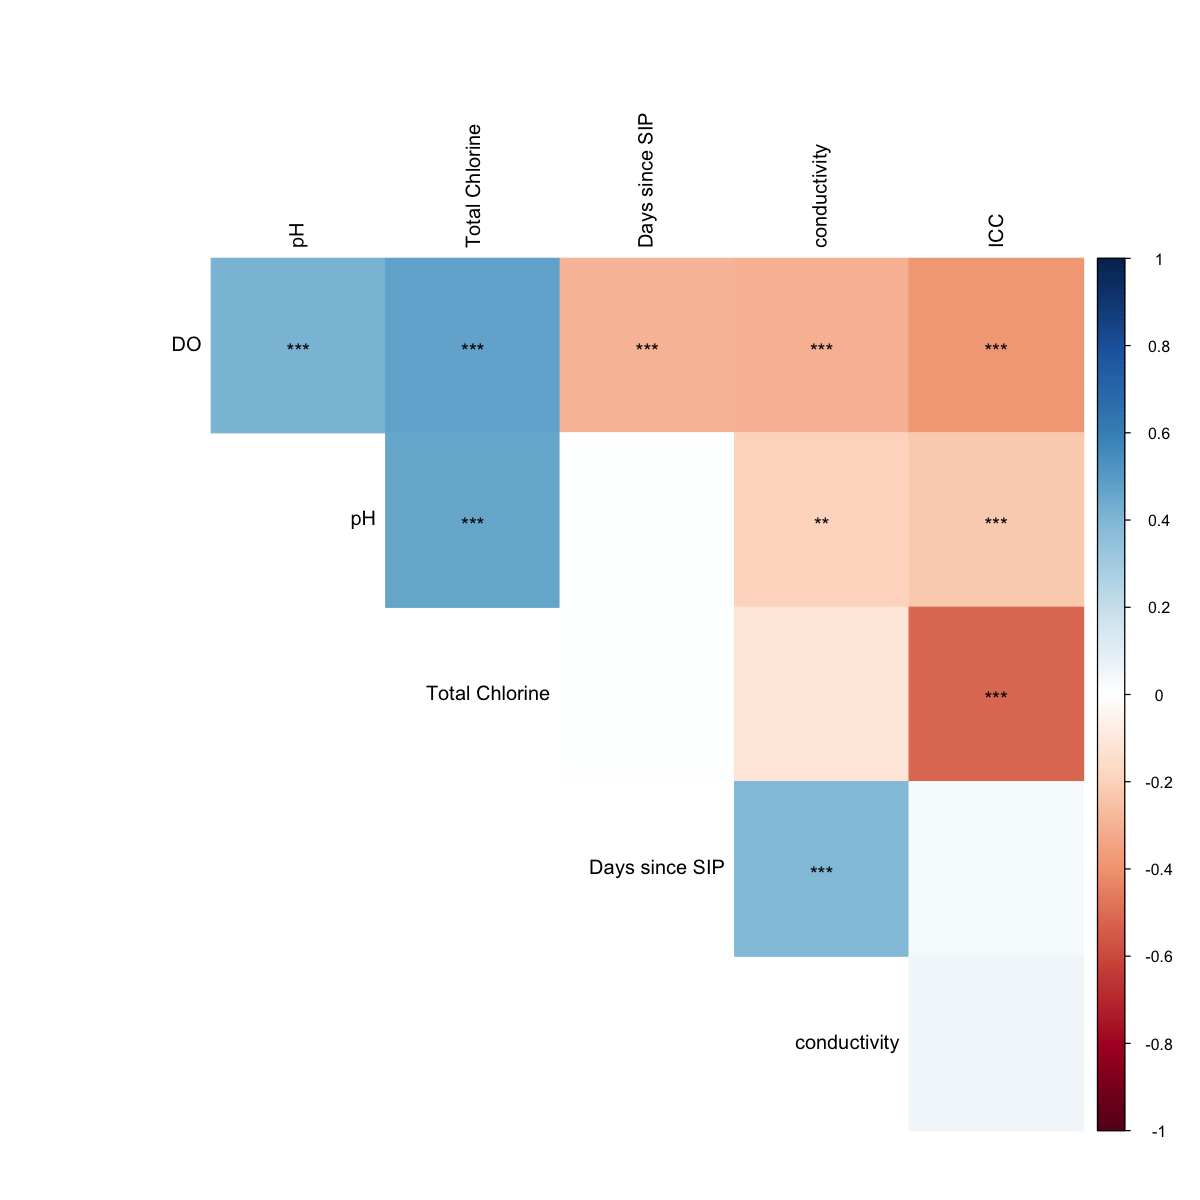

In [286]:
#create correlation matrix using kendall's tau-b

keep_bio= c( "days_since_full_occupancy", "pH", "DO",  "conductivity", "cl_total", "ICC")
df_corr <- data_all %>% subset(building != "control")  %>% select(all_of(keep_bio))%>% drop_na() 

#temperature was not significantly correlated with anything
#TCC looks really similar to ICC
#free chlorine looks similar to total chlorine but weaker relationshsips

#corr analyses
#http://www.sthda.com/english/wiki/correlation-analyses-in-r
##correlation matrix using kendall's tau with all data

length(df_corr$ICC) #106 if pre and post included, 83 if just pre

#rename columns to be nicer looking
# colnames(df_corr)[which(names(df_corr) == "building_age")] <- "Building Age"
colnames(df_corr)[which(names(df_corr) == "cl_total")] <- "Total Chlorine"
colnames(df_corr)[which(names(df_corr) == "days_since_full_occupancy")] <- "Days since SIP"

options(repr.plot.width = 10, repr.plot.height = 10)
M <-cor(df_corr, method="kendall")
M
res1 <- cor.mtest(df_corr, method ="kendall", conf.level = .95)
corr1<- corrplot(M, p.mat = res1$p, method = "color", diag = FALSE, type = "upper",sig.level = c(.001, .01, .05), pch.cex = 1, insig = "label_sig", pch.col = "black", order = "AOE", tl.col = "black")
# p-values *** = 0.001, ** = 0.01 and * =0.05

ggsave(paste0(fig_dir, 'FigureS3.jpeg'), width=10, height=10)

In [227]:
#using GGally package for exploratory data analysis
options(repr.plot.width = 12, repr.plot.height = 12) #change the size of the plot
theme_set(theme_classic(base_size=14))# set font size

#keep TCC, ICC and parameters that seem to be correlated
keep_bio= c( "days_since_full_occupancy", "temp", "pH", "DO",  "conductivity", "cl_total", "cl_free",  "Cu",  "TCC", "ICC", "Percent_intact")
df_bio <- data_all %>% subset(building != "control")  %>% select(all_of(keep_bio)) #%>% subset(flush=="pre")

# ggpairs(df_bio) 

#explore relationships between metals and physicochemical parameters
# keep_metals= c( "days_since_full_occupancy", "temp", "pH", "DO", "Na", "Cr", "Ni", "As", "Ag", "Cd", "Mg", "Zn", "conductivity",  "TOC.ppm", "Fe", "Pb", "Cu", "Mn", "nitrate_avg")
# df_metals <- df_samples %>% subset(flush=="pre") %>% select(all_of(keep_metals))
# ggpairs(df_metals)



In [228]:
#significance tests
plt_data <- data_all %>% subset(building != "control")%>% subset(building == "D")


#stats test
kruskal.test(ICC ~ flush, data = plt_data) #not different

#stats test
kruskal.test(DO ~ flush, data = plt_data) #not different


	Kruskal-Wallis rank sum test

data:  ICC by flush
Kruskal-Wallis chi-squared = 20.63, df = 3, p-value = 0.0001257



	Kruskal-Wallis rank sum test

data:  DO by flush
Kruskal-Wallis chi-squared = 3.7406, df = 3, p-value = 0.2909


In [229]:
#summary table of total samples 

t1<- df  %>% group_by(building, pre_post) %>% dplyr::summarise(n=n())
t1 <- as.data.frame(t1)
t1

t2<- data_all  %>% drop_na(ICC) %>% count(building, sort= TRUE) 
t2 <- as.data.frame(t2)
t2


`summarise()` has grouped output by 'building'. You can override using the
`.groups` argument.


building,pre_post,n
<chr>,<chr>,<int>
BC,pre,14
control,pre,1
davis,main,2
davis,post,18
davis,pre,63
SB,pre,24


building,n
<ord>,<int>
D,83
S,24
B,14


# qPCR plots

In [230]:
#qPCR heat map for amoA

df_AmoA <- data_all  %>% filter(building != "control") %>% drop_na(positivity_AmoA)

#set order to positivity
df_AmoA$positivity_AmoA<- factor(df_AmoA$positivity_AmoA, order = TRUE, levels =c('0 reps', '1 rep', '<LoD', '<LoQ', 'quantifiable'))


fig_2b <- (ggplot(df_AmoA, aes(x=date_formal, y=tap_code, fill=positivity_AmoA))+
geom_tile(aes(width=0.85, height=0.85), color='black')+
# scale_fill_manual(values=c('#FFFFFF','#4EBA9F', '#337A69', '#193B32'))+
          scale_fill_manual(values=c('#FFFFFF','#92c5de', '#f4a582', '#ca0020'))+
geom_vline(xintercept= 3.5, color= "black", linetype= "dashed")+
           ylab('')+
xlab('Date of sample collection')+
ggtitle('amoA')+
facet_wrap(~building, ncol=1, scales= "free_y")+
           guides(fill=guide_legend(title="Positivity"))+
theme_classic()+
        theme(axis.text.x = element_text(angle = 45, hjust=1)))
options(repr.plot.width = 6, repr.plot.height = 10)


In [231]:
#qPCR heat map for mip

df_mip <- data_all  %>% filter(building != "control") %>% drop_na(positivity_mip)

#set order to positivity
df_mip$positivity_mip<- factor(df_mip$positivity_mip, order = TRUE, levels =c('0 reps', '1 rep', '<LoD', '<LoQ', 'quantifiable'))


fig_2a <- (ggplot(df_mip, aes(x=date_formal, y=tap_code, fill=positivity_mip))+
geom_tile(aes(width=0.85, height=0.85), color='black')+
# scale_fill_manual(values=c('#FFFFFF','#4EBA9F', '#337A69', '#193B32'))+
#         scale_fill_manual(values=c('#FFFFFF','#69A3FA', '#D2FA50', '#FA452F'))+
        scale_fill_manual(values=c('#FFFFFF','#92c5de', '#f4a582', '#ca0020'))+
            guides(fill=guide_legend(title="Positivity"))+
           geom_vline(xintercept= 3.5, color= "black", linetype= "dashed")+
ylab('')+
xlab('Date of sample collection')+
ggtitle('mip')+
facet_wrap(~building, ncol=1, scales= "free_y")+
theme_classic()+
        theme(axis.text.x = element_text(angle = 45, hjust=1)))
options(repr.plot.width = 6, repr.plot.height = 10)
# theme( axis_ticks_minor_y=element_blank(), axis_ticks_major_y=element_blank(),  axis_text_y=element_blank(),  axis_text_x=element_text(angle=45, hjust=1)))
# fig_2a
# ggsave(plt, 'heatmap_mip.png')

In [232]:
#qPCR heat map for MAC

df_MAC <- data_all  %>% filter(building != "control") %>% drop_na(positivity_MAC)

#set order to positivity
df_MAC$positivity_MAC<- factor(df_MAC$positivity_MAC, order = TRUE, levels =c('0 reps', '1 rep', '<LoD', '<LoQ', 'quantifiable'))


fig_2d <- (ggplot(df_MAC, aes(x=date_formal, y=tap_code, fill=positivity_MAC))+
geom_tile(aes(width=0.85, height=0.85), color='black')+
# scale_fill_manual(values=c('#FFFFFF','#4EBA9F', '#337A69', '#193B32'))+
          scale_fill_manual(values=c('#FFFFFF','#92c5de', '#f4a582', '#ca0020'))+
           geom_vline(xintercept= 3.5, color= "black", linetype= "dashed")+
ylab('')+
xlab('Date of sample collection')+
ggtitle('MAC')+
facet_wrap(~building, ncol=1, scales= "free_y")+
           guides(fill=guide_legend(title="Positivity"))+
theme_classic()+
        theme(axis.text.x = element_text(angle = 45, hjust=1)))
options(repr.plot.width = 6, repr.plot.height = 10)


In [233]:
#qPCR heat map for Ps

df_Ps <- data_all  %>% filter(building != "control") %>% drop_na(positivity_Ps)

#set order to positivity
df_Ps$positivity_Ps<- factor(df_Ps$positivity_Ps, order = TRUE, levels =c('0 reps', '1 rep', '<LoD', '<LoQ', 'quantifiable'))


fig_2c <- (ggplot(df_Ps, aes(x=date_formal, y=tap_code, fill=positivity_Ps))+
geom_tile(aes(width=0.85, height=0.85), color='black')+
        scale_fill_manual(values=c('#FFFFFF','#92c5de', '#f4a582', '#ca0020'))+
            guides(fill=guide_legend(title="Positivity"))+
           geom_vline(xintercept= 3.5, color= "black", linetype= "dashed")+
ylab('')+
xlab('Date of sample collection')+
ggtitle('Ps')+
facet_wrap(~building, ncol=1, scales= "free_y")+
theme_classic()+
        theme(axis.text.x = element_text(angle = 45, hjust=1)))
options(repr.plot.width = 6, repr.plot.height = 10)


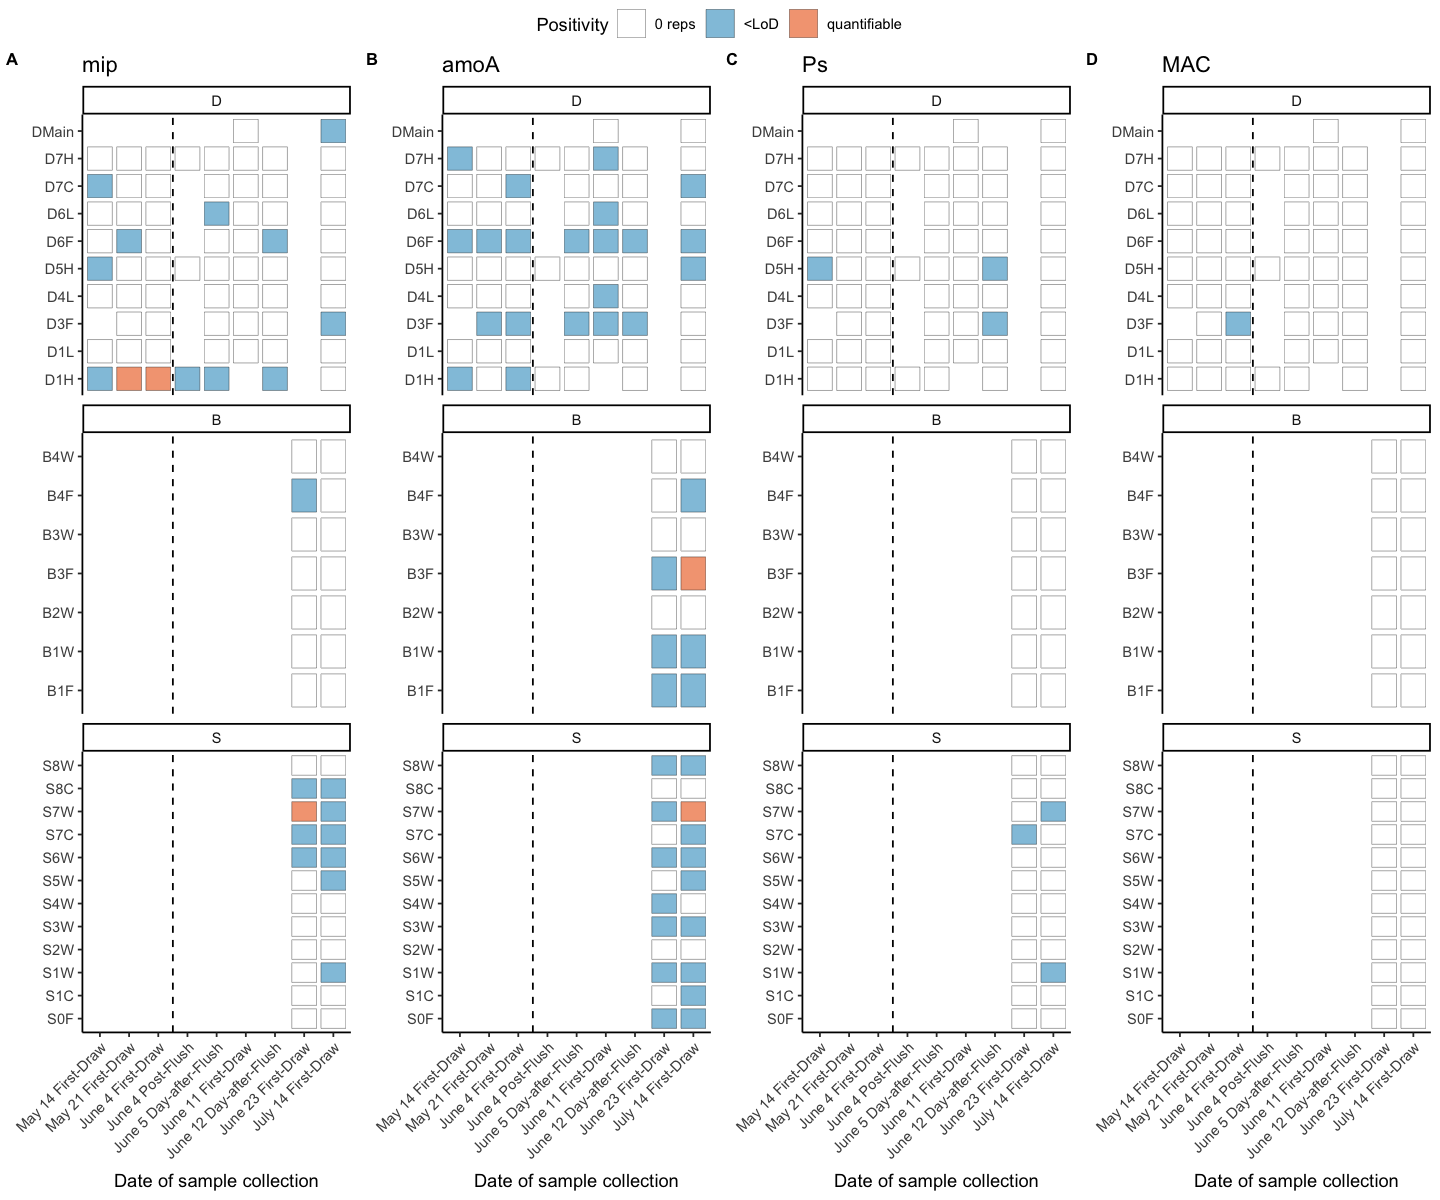

In [234]:
#arrange plots for figure together
options(repr.plot.width = 12, repr.plot.height = 10)
fig_2<- ggarrange(fig_2a,fig_2b,fig_2c, fig_2d, ncol=4, nrow=1, labels= c("A", "B", "C", "D"), font.label = list(size = 10, color = "black", face = "bold", family = NULL), legend = "top", common.legend = T, align = c("hv"))
fig_2

ggsave(paste0(fig_dir, 'Figure7.jpeg'), width=12, height=10)


In [235]:
# Question: Did cell counts impact the presence of amoA/mip in the sample?

options(repr.plot.width = 8, repr.plot.height = 4)
ICC_amoA <- ggplot(df_AmoA, aes(x= positivity_AmoA, y=ICC, fill=positivity_AmoA))+
geom_boxplot(lwd=0.75)+
# stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
xlab('qPCR amoA positivity')+
# geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
geom_jitter(aes(fill= tap_code), width = 0.2, shape=21, color="black", size=3.3, alpha=0.8)+
scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)), limits=c(1e3, 1e6))+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
ylab('ICC (cells/mL)')+
scale_fill_viridis_d(option="D")+
theme(panel.background=element_blank(),legend.position="none", panel.border=element_rect(color = "black", fill = NA))
# ggsave(paste0(fig_dir, 'ICC_amoA.png'), width=8, height=4)

options(repr.plot.width = 8, repr.plot.height = 4)
ICC_mip <- ggplot(df_mip, aes(x= positivity_mip, y=ICC, fill=positivity_mip))+
geom_boxplot(lwd=0.75)+
stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
xlab('qPCR mip positivity')+
# geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
geom_jitter(aes(fill= tap_code), width = 0.2, shape=21, color="black", size=3.3, alpha=0.8)+
scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)), limits=c(1e3, 1e6))+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
ylab('ICC (cells/mL)')+
scale_fill_viridis_d(option="D")+
theme(panel.background=element_blank(),legend.position="none", panel.border=element_rect(color = "black", fill = NA))


In [236]:
#stats test for ICC based on amoA
# one.way <- aov(ICC ~ positivity_AmoA, data = df_AmoA)
# summary(one.way) #not statistically significant differences in ICC based on amoA presence

kruskal.test(ICC ~ positivity_AmoA, data = df_AmoA) #yes, statistically significant differences in ICC based on amoA presence
wilcox.test(df_AmoA$ICC[df_AmoA$positivity_AmoA== "0 reps"], df_AmoA$ICC[df_AmoA$positivity_AmoA== "<LoD" |df_AmoA$positivity_AmoA== "quantifiable"], conf.level= 0.95)
# wilcox.test(df_AmoA$ICC[df_AmoA$positivity_AmoA== "0 reps"], df_AmoA$ICC[df_AmoA$positivity_AmoA== "quantifiable"], conf.level= 0.95)
# wilcox.test(df_AmoA$ICC[df_AmoA$positivity_AmoA== "quantifiable"], df_AmoA$ICC[df_AmoA$positivity_AmoA== "<LoD"], conf.level= 0.95)

#stats test ICC based on mip
# one.way <- aov(ICC ~ positivity_mip, data = df_mip)
# summary(one.way) #not statistically significant differences in ICC based on mip presence
kruskal.test(ICC ~ positivity_mip, data = df_mip) #not statistically significant differences in ICC based on mip presence


	Kruskal-Wallis rank sum test

data:  ICC by positivity_AmoA
Kruskal-Wallis chi-squared = 14.466, df = 2, p-value = 0.0007223



	Wilcoxon rank sum test with continuity correction

data:  df_AmoA$ICC[df_AmoA$positivity_AmoA == "0 reps"] and df_AmoA$ICC[df_AmoA$positivity_AmoA == "<LoD" | df_AmoA$positivity_AmoA == "quantifiable"]
W = 747, p-value = 0.0001654
alternative hypothesis: true location shift is not equal to 0



	Kruskal-Wallis rank sum test

data:  ICC by positivity_mip
Kruskal-Wallis chi-squared = 0.29134, df = 2, p-value = 0.8644


In [237]:
#stats test for NH4 based on amoA

kruskal.test(NH4_avg ~ positivity_AmoA, data = df_AmoA) #no, not statistically significant differences
kruskal.test(nitrite_avg ~ positivity_AmoA, data = df_AmoA)
kruskal.test(nitrate_avg ~ positivity_AmoA, data = df_AmoA)

NH4_amoA <- ggplot(df_AmoA, aes(x= positivity_AmoA, y=NH4_avg, fill=positivity_AmoA))+
geom_boxplot(lwd=0.75)+
stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
xlab('qPCR amoA positivity')+
# geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
geom_jitter(aes(fill= tap_code), width = 0.2, shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
ylab('Ammonium\n(mg/L)')+
scale_fill_viridis_d(option="D")+
theme(panel.background=element_blank(),legend.position="none", panel.border=element_rect(color = "black", fill = NA))



	Kruskal-Wallis rank sum test

data:  NH4_avg by positivity_AmoA
Kruskal-Wallis chi-squared = 8.0944, df = 2, p-value = 0.01747



	Kruskal-Wallis rank sum test

data:  nitrite_avg by positivity_AmoA
Kruskal-Wallis chi-squared = 2.6955, df = 2, p-value = 0.2598



	Kruskal-Wallis rank sum test

data:  nitrate_avg by positivity_AmoA
Kruskal-Wallis chi-squared = 0.35291, df = 2, p-value = 0.8382


In [238]:
#Question: Did presence of amoA impact the amount of nitrate in the sample?

#make a boxplot to compare nitrate and amoA data

options(repr.plot.width = 8, repr.plot.height = 4)

nitrate_amoA <- ggplot(df_AmoA, aes(x= positivity_AmoA, y=nitrate_avg, fill=positivity_AmoA))+
geom_boxplot(lwd=0.75)+
stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
xlab('qPCR amoA positivity')+
# geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
geom_jitter(aes(fill= tap_code), width = 0.2, shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
ylab('Nitrate\n(mg/L)')+
scale_fill_viridis_d(option="D")+
theme(panel.background=element_blank(),legend.position="none", panel.border=element_rect(color = "black", fill = NA))

# ggsave(paste0(fig_dir, 'nitrate_amoA.png'), width=8, height=4)

#stats test
# one.way <- aov(nitrate_avg ~ positivity_AmoA, data = df_AmoA)
# summary(one.way) #not statistically significant differences in nitrate conc based on amoA presence

one.way <- kruskal.test(nitrate_avg ~ positivity_AmoA, data = df_AmoA)
one.way #no statistically significant differences in nitrate based on amoA presence


	Kruskal-Wallis rank sum test

data:  nitrate_avg by positivity_AmoA
Kruskal-Wallis chi-squared = 0.35291, df = 2, p-value = 0.8382


In [239]:
#Question: Did presence of amoA impact the amount of total chlorine in the sample?

#make a boxplot to compare nitrate and amoA data

options(repr.plot.width = 8, repr.plot.height = 4)

cl_amoA <-ggplot(df_AmoA, aes(x= positivity_AmoA, y=cl_total, fill=positivity_AmoA))+
geom_boxplot(lwd=0.75)+
stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
xlab('qPCR amoA positivity')+
# geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
geom_jitter(aes(fill= tap_code), width = 0.2, shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
ylab('Total Chlorine\n(mg/L)')+
scale_fill_viridis_d(option="D")+
theme(panel.background=element_blank(),legend.position="none", panel.border=element_rect(color = "black", fill = NA))

# ggsave(paste0(fig_dir, 'nitrate_amoA.png'), width=8, height=4)

In [240]:
#stats tests related to chlorine
#amoA
kruskal.test(cl_total ~ positivity_AmoA, data = df_AmoA) #yes, statistically significant differences in chlorine based on amoA presence
wilcox.test(df_AmoA$cl_total[df_AmoA$positivity_AmoA== "0 reps"], df_AmoA$cl_total[df_AmoA$positivity_AmoA== "<LoD" |df_AmoA$positivity_AmoA== "quantifiable"], conf.level= 0.95)

#mip
kruskal.test(cl_total ~ positivity_mip, data = df_mip) #not statistically significant differences in chlorine based on amoA presence



	Kruskal-Wallis rank sum test

data:  cl_total by positivity_AmoA
Kruskal-Wallis chi-squared = 26.979, df = 2, p-value = 1.386e-06



	Wilcoxon rank sum test with continuity correction

data:  df_AmoA$cl_total[df_AmoA$positivity_AmoA == "0 reps"] and df_AmoA$cl_total[df_AmoA$positivity_AmoA == "<LoD" | df_AmoA$positivity_AmoA == "quantifiable"]
W = 2108.5, p-value = 2.095e-07
alternative hypothesis: true location shift is not equal to 0



	Kruskal-Wallis rank sum test

data:  cl_total by positivity_mip
Kruskal-Wallis chi-squared = 1.3908, df = 2, p-value = 0.4989


In [241]:
#Question: Did Mn impact the amount of mip in the sample?

options(repr.plot.width = 8, repr.plot.height = 4)

Mn_mip <- ggplot(df_mip, aes(x= positivity_mip, y=Mn, fill=positivity_mip))+
geom_boxplot(lwd=0.75)+
# stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
xlab('qPCR mip positivity')+
# geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
geom_jitter(aes(fill= tap_code), width = 0.2, shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
ylab('Mn (ppb)')+
scale_fill_viridis_d(option="D")+
theme(panel.background=element_blank(),legend.position="none", panel.border=element_rect(color = "black", fill = NA))

# ggsave(paste0(fig_dir, 'Mn_mip.png'), width=8, height=4)

#stats test
# one.way <- aov(Mn ~ positivity_mip, data = df_mip)
# summary(one.way) #statistically significant differences in Mn and Fe conc based on mip presence

kruskal.test(Mn ~ positivity_mip, data = df_mip) #not different


	Kruskal-Wallis rank sum test

data:  Mn by positivity_mip
Kruskal-Wallis chi-squared = 5.0284, df = 2, p-value = 0.08093


In [242]:
#Question: Did Fe impact the amount of mip in the sample?

options(repr.plot.width = 8, repr.plot.height = 4)

Fe_mip <- ggplot(df_mip, aes(x= positivity_mip, y=Fe, fill=positivity_mip))+
geom_boxplot(lwd=0.75)+
# stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
xlab('qPCR mip positivity')+
geom_jitter(aes(fill= tap_code), width = 0.2, shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
ylab('Fe (ppb)')+
scale_fill_viridis_d(option="D")+
theme(panel.background=element_blank(),legend.position="none", panel.border=element_rect(color = "black", fill = NA))

# ggsave(paste0(fig_dir, 'Fe_mip.png'), width=8, height=4)

#stats test
# one.way <- aov(Fe ~ positivity_mip, data = df_mip)
# summary(one.way) #statistically significant differences in Mn and Fe conc based on mip presence
kruskal.test(Fe ~ positivity_mip, data = df_mip) #not different


	Kruskal-Wallis rank sum test

data:  Fe by positivity_mip
Kruskal-Wallis chi-squared = 3.9463, df = 2, p-value = 0.139


In [243]:
#Question: Did Fe impact the amount of mip in the sample?

options(repr.plot.width = 8, repr.plot.height = 4)

cl_mip <- ggplot(df_mip, aes(x= positivity_mip, y=cl_total, fill=positivity_mip))+
geom_boxplot(lwd=0.75)+
# stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
xlab('qPCR mip positivity')+
geom_jitter(aes(fill= tap_code), width = 0.2, shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
ylab('Total Chlorine (mg/L)')+
scale_fill_viridis_d(option="D")+
theme(panel.background=element_blank(),legend.position="none", panel.border=element_rect(color = "black", fill = NA))
# ggsave(paste0(fig_dir, 'Fe_mip.png'), width=8, height=4)

#stats test
# one.way <- aov(Fe ~ positivity_mip, data = df_mip)
# summary(one.way) #statistically significant differences in Mn and Fe conc based on mip presence
kruskal.test(Fe ~ positivity_mip, data = df_mip) #not different


	Kruskal-Wallis rank sum test

data:  Fe by positivity_mip
Kruskal-Wallis chi-squared = 3.9463, df = 2, p-value = 0.139


Warning message:
“Removed 12 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 12 rows containing missing values (geom_point).”
Warning message:
“Removed 12 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 12 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 3 rows containing missing values (geom_text).”
Warning message:
“Removed 12 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 7 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”
Warning message:
“Removed 23 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 23 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 23 rows containing missing values (geom_point).”


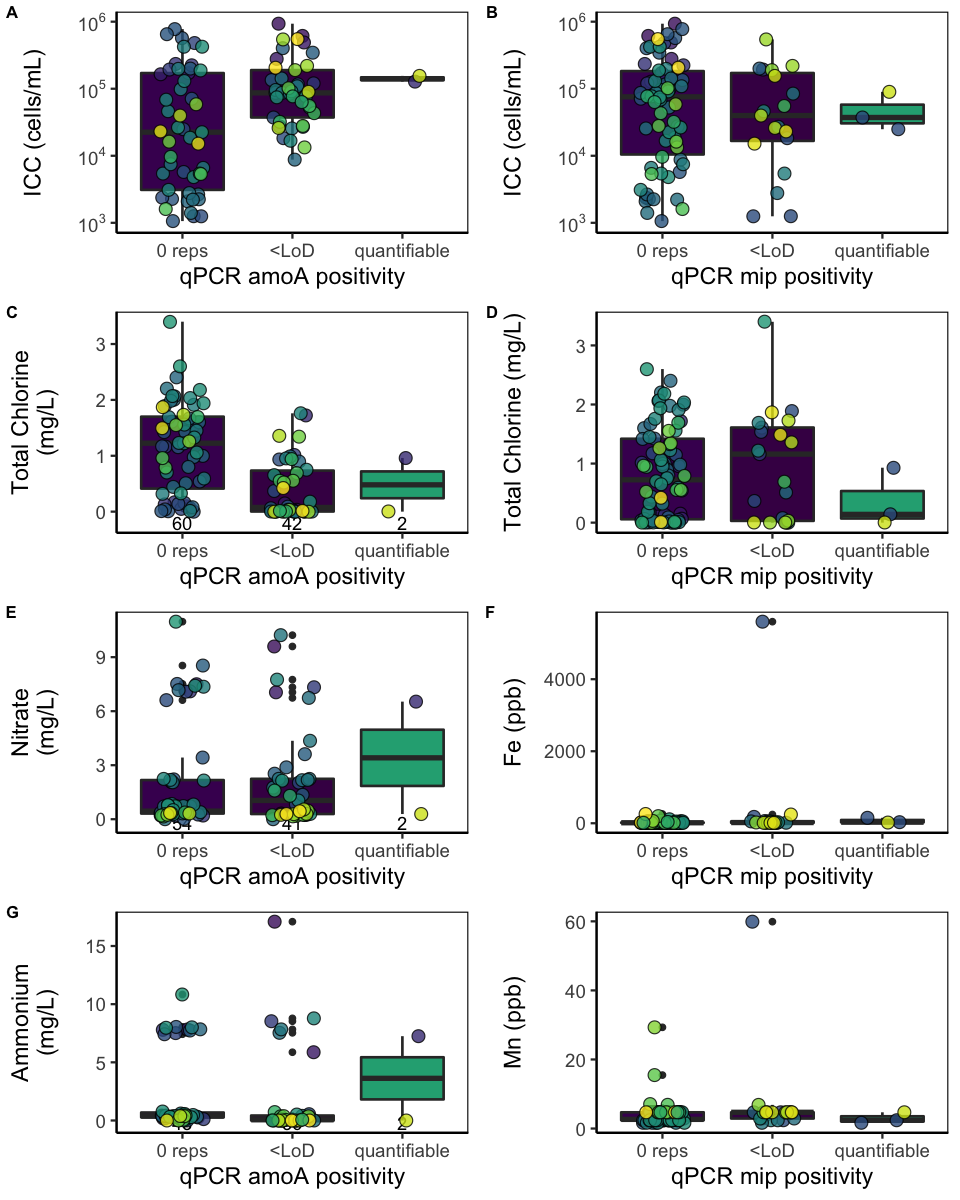

In [244]:
options(repr.plot.width = 8, repr.plot.height = 10)
ggarrange(ICC_amoA, ICC_mip, cl_amoA, cl_mip, nitrate_amoA, Fe_mip, NH4_amoA, Mn_mip, ncol= 2, nrow=4, labels= c("A", "B", "C", "D", "E", "F", "G"), font.label = list(size = 10, color = "black", face = "bold", family = NULL), legend = NULL,  align = c("hv"))
ggsave(paste0(fig_dir, 'FigureS13.jpeg'), width=8, height=10)


# Stagnation impacts and flushing experiments

## organize and subset data

In [245]:
# pivot full data (includes qPCR and everything) to long form
data_all_melt <- pivot_longer(data_all,
                        cols = c('ICC', 'Pb', 'Cu',  'cl_total','temp', 'DO', 'conductivity', 'pH', 'Mn', 'Fe', 'Zn', 'nitrate_avg'),
                        names_to = 'assay',
                        values_to = 'value')
data_all_melt$assay <- as.factor(data_all_melt$assay)
data_all_melt$assay <- factor(data_all_melt$assay, levels = c('cl_total', 'ICC', 'Pb', 'Cu','temp', 'DO', 'conductivity', 'pH', 'Mn', 'Fe', 'Zn', 'nitrate_avg'))
# head(data_all_melt)

In [246]:
#create a new column for fixture type with better grouping (hot/mixed sink, cold sink, lab/industrial sink, shower, fountain)
# data_all$fixture_type <- NA
data_all <- data_all %>% add_column(fixture_type = NA)
data_all$fixture_type<- data_all$type
data_all$fixture_type[(data_all$fixture_type == "bathroom" | data_all$fixture_type == "kitchen") & (data_all$hot_or_cold == "hot/mixed")] <- "hot/mixed faucet"
data_all$fixture_type[(data_all$fixture_type == "bathroom" | data_all$fixture_type == "kitchen") & (data_all$hot_or_cold == "cold")] <- "cold faucet"


In [247]:
#subset out controls
df_nocontrol <- data_all[!data_all$building == 'control', ]

#remove building main samples
df_nocontrol_nomain <- filter(df_nocontrol, tap_code != "DMain")

In [248]:
#find conc ranges for targets for all samples in the study (no controls)

#summary stats
data_all %>% filter(building != "control") %>% select(TOC.ppm, temp, pH, DO, conductivity, Percent_intact, cl_total, cl_free, nitrate_avg, ICC, TCC, Pb, Cu, Fe, Mn, Zn) %>% summary()


    TOC.ppm           temp             pH              DO       
 Min.   :0.410   Min.   :13.10   Min.   :6.850   Min.   :3.020  
 1st Qu.:1.185   1st Qu.:21.50   1st Qu.:8.640   1st Qu.:7.440  
 Median :1.296   Median :22.80   Median :9.090   Median :8.490  
 Mean   :1.703   Mean   :23.37   Mean   :8.804   Mean   :7.898  
 3rd Qu.:1.648   3rd Qu.:24.50   3rd Qu.:9.250   3rd Qu.:8.960  
 Max.   :8.237   Max.   :39.60   Max.   :9.420   Max.   :9.710  
 NA's   :34                                                     
  conductivity    Percent_intact     cl_total         cl_free      
 Min.   : 67.52   Min.   : 4.09   Min.   :0.0000   Min.   :0.0000  
 1st Qu.: 76.97   1st Qu.:27.97   1st Qu.:0.0600   1st Qu.:0.0200  
 Median : 84.54   Median :49.03   Median :0.9000   Median :0.0800  
 Mean   : 88.13   Mean   :46.79   Mean   :0.9426   Mean   :0.1946  
 3rd Qu.: 91.40   3rd Qu.:64.54   3rd Qu.:1.6300   3rd Qu.:0.1700  
 Max.   :165.80   Max.   :85.83   Max.   :3.4000   Max.   :2.8000  
 NA'

In [249]:
# just nitrate
data_all %>% filter(building != "control") %>% filter(date_cat %in% c("6/4_pre", "6/4_post", "6/5_pre", "6/11_pre", "6/11_post", "6/12_pre")) %>% 
select(nitrate_avg,NH4_avg, flush) %>% group_by(flush) %>%
dplyr::summarise(mean_NH4= mean(NH4_avg, na.rm= TRUE), mean_nit= mean(nitrate_avg, na.rm= TRUE), ratio= mean_nit/mean_NH4) %>% 
ungroup()  

mean(data_all$NH4_avg[data_all$date_cat != "7/14_pre"], na.rm= TRUE)
mean(data_all$NH4_avg[data_all$date_cat == "7/14_pre"], na.rm= TRUE)


flush,mean_NH4,mean_nit,ratio
<fct>,<dbl>,<dbl>,<dbl>
pre,0.2480578,0.8434119,3.4000623
post,0.3019631,0.5160821,1.7090898
day after flush,0.3283574,0.8098630,2.4664069
main,0.3136667,0.2843667,0.9065887


[1] 0.2684316

[1] 4.995992

In [250]:
#find conc ranges for targets for only first-draw samples in the study (no controls)

#summary stats
data_all %>% filter(building != "control") %>% filter(flush == "pre") %>% select(TOC.ppm, temp, pH, DO, Percent_intact, conductivity, cl_total, cl_free, nitrate_avg, ICC, TCC, Pb, Cu, Fe, Mn, Zn) %>% summary()


    TOC.ppm           temp             pH              DO       
 Min.   :0.410   Min.   :13.10   Min.   :7.060   Min.   :3.020  
 1st Qu.:1.184   1st Qu.:21.35   1st Qu.:8.685   1st Qu.:6.545  
 Median :1.253   Median :22.70   Median :9.090   Median :8.130  
 Mean   :1.675   Mean   :23.57   Mean   :8.842   Mean   :7.575  
 3rd Qu.:1.562   3rd Qu.:24.35   3rd Qu.:9.240   3rd Qu.:8.830  
 Max.   :8.237   Max.   :39.60   Max.   :9.390   Max.   :9.680  
 NA's   :10                                                     
 Percent_intact   conductivity       cl_total         cl_free      
 Min.   :17.46   Min.   : 67.52   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:41.48   1st Qu.: 79.08   1st Qu.:0.0300   1st Qu.:0.0100  
 Median :53.00   Median : 85.10   Median :0.5200   Median :0.0500  
 Mean   :52.53   Mean   : 90.22   Mean   :0.6184   Mean   :0.1743  
 3rd Qu.:66.20   3rd Qu.: 95.48   3rd Qu.:1.0350   3rd Qu.:0.1000  
 Max.   :85.83   Max.   :165.80   Max.   :1.8700   Max.   :1.5800  
    

In [251]:
#find conc ranges for targets for only first-draw samples in the study (no controls)

#summary stats
data_all %>% filter(building != "control") %>% filter(flush == "main") %>% select(TOC.ppm, temp, pH, DO, conductivity, cl_total, cl_free, nitrate_avg, ICC, TCC, Pb, Cu, Fe, Mn, Zn) %>% summary()


    TOC.ppm           temp             pH             DO       
 Min.   :1.421   Min.   :20.90   Min.   :9.21   Min.   :8.750  
 1st Qu.:1.421   1st Qu.:21.05   1st Qu.:9.26   1st Qu.:8.803  
 Median :1.421   Median :21.20   Median :9.31   Median :8.855  
 Mean   :1.421   Mean   :21.20   Mean   :9.31   Mean   :8.855  
 3rd Qu.:1.421   3rd Qu.:21.35   3rd Qu.:9.36   3rd Qu.:8.908  
 Max.   :1.421   Max.   :21.50   Max.   :9.41   Max.   :8.960  
 NA's   :1                                                     
  conductivity       cl_total      cl_free        nitrate_avg     
 Min.   : 85.98   Min.   :2.6   Min.   :0.1000   Min.   : 0.2844  
 1st Qu.: 91.36   1st Qu.:2.8   1st Qu.:0.2775   1st Qu.: 2.9559  
 Median : 96.74   Median :3.0   Median :0.4550   Median : 5.6274  
 Mean   : 96.74   Mean   :3.0   Mean   :0.4550   Mean   : 5.6274  
 3rd Qu.:102.12   3rd Qu.:3.2   3rd Qu.:0.6325   3rd Qu.: 8.2989  
 Max.   :107.50   Max.   :3.4   Max.   :0.8100   Max.   :10.9704  
                   

In [252]:
#find conc ranges for targets for only first-draw samples in the study (no controls)

#summary stats
data_all %>% filter(building != "control") %>% filter(cl_total < 0.02) %>% select(ICC, TCC, Percent_intact) %>% summary()


      ICC              TCC          Percent_intact 
 Min.   : 20026   Min.   :  41895   Min.   :41.32  
 1st Qu.: 73903   1st Qu.: 135812   1st Qu.:61.97  
 Median :142300   Median : 226385   Median :68.56  
 Mean   :273985   Mean   : 455887   Mean   :66.41  
 3rd Qu.:483283   3rd Qu.: 830938   3rd Qu.:73.65  
 Max.   :933042   Max.   :1266880   Max.   :80.88  
                  NA's   :2         NA's   :2      

In [253]:
#find conc ranges for targets for only dorm samples in the study (no controls)

#summary stats
data_all %>% filter(building != "control") %>% filter(building == "B" | building == "S") %>% select(TOC.ppm, temp, pH, DO, conductivity, cl_total, cl_free, nitrate_avg, ICC, TCC, Pb, Cu, Fe, Mn, Zn) %>% summary()


    TOC.ppm           temp             pH              DO       
 Min.   :0.410   Min.   :15.10   Min.   :7.180   Min.   :3.020  
 1st Qu.:1.203   1st Qu.:21.70   1st Qu.:8.775   1st Qu.:6.388  
 Median :1.422   Median :24.20   Median :9.050   Median :7.915  
 Mean   :1.843   Mean   :25.86   Mean   :8.909   Mean   :7.317  
 3rd Qu.:1.990   3rd Qu.:29.23   3rd Qu.:9.277   3rd Qu.:8.457  
 Max.   :6.323   Max.   :39.60   Max.   :9.390   Max.   :9.040  
                                                                
  conductivity       cl_total         cl_free        nitrate_avg    
 Min.   : 76.32   Min.   :0.0000   Min.   :0.0000   Min.   :0.1508  
 1st Qu.: 83.83   1st Qu.:0.0300   1st Qu.:0.0200   1st Qu.:0.2424  
 Median : 86.50   Median :0.4700   Median :0.0800   Median :0.3131  
 Mean   : 91.46   Mean   :0.6184   Mean   :0.1882   Mean   :1.7063  
 3rd Qu.: 98.60   3rd Qu.:1.1225   3rd Qu.:0.1400   3rd Qu.:0.5452  
 Max.   :125.40   Max.   :1.8700   Max.   :1.2000   Max.   :9.5938

In [254]:
#create a subset df with only the first three dates in davis

#decrease percent through flushing
# df_nocontrol_nomain %>% subset(building == "D" & (date_cat == "5/14_pre"|date_cat == "5/21_pre"|date_cat == "6/4_pre")) %>% dplyr::summarise(gmean= exp(mean(log(ICC))))
c1<- df_nocontrol_nomain %>% subset(building == "D" & (date_cat == "6/4_pre")) %>% dplyr::summarise(gmean= exp(mean(log(ICC))))
c2 <- df_nocontrol_nomain %>% subset(building == "D" & (date_cat == "6/4_post")) %>% dplyr::summarise(gmean= exp(mean(log(ICC))))
(c1[1]-c2[1])/c1[1]

#regrowth percent through flushing
c1<- df_nocontrol_nomain %>% subset(building == "D" & (date_cat == "6/4_post")) %>% dplyr::summarise(gmean= exp(mean(log(ICC))))
c2 <- df_nocontrol_nomain %>% subset(building == "D" & (date_cat == "6/11_pre")) %>% dplyr::summarise(gmean= exp(mean(log(ICC))))
(c2[1]-c1[1])/c1[1]


gmean
<dbl>
0.944555


gmean
<dbl>
6.444457


In [255]:
# pivot data to long form for plotting
nocontrol_long <- pivot_longer(df_nocontrol_nomain,
                        cols = c('ICC', 'pH','Pb', 'Cu', 'Fe', 'cl_total','cl_free','temp', 'DO', 'conductivity', 'nitrate_avg', 'TOC.ppm'),
                        names_to = 'assay',
                        values_to = 'value')

unique(nocontrol_long$building)

[1] B D S
Levels: D < B < S < control

Warning message in trans$transform(limits):
“NaNs produced”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 16 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 16 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 16 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 16 rows containing non-finite values (stat_summary).”


[1] 104471.7

`summarise()` has grouped output by 'building', 'fixture_type'. You can
override using the `.groups` argument.


building,fixture_type,flush,gmean
<ord>,<chr>,<fct>,<dbl>
D,cold faucet,pre,35330.206
D,cold faucet,post,19655.152
D,cold faucet,day after flush,7593.972
D,fountain,pre,161771.315
D,fountain,post,24100.158
D,fountain,day after flush,51334.444
D,hot/mixed faucet,pre,10810.356
D,hot/mixed faucet,post,1856.005
D,hot/mixed faucet,day after flush,1535.677


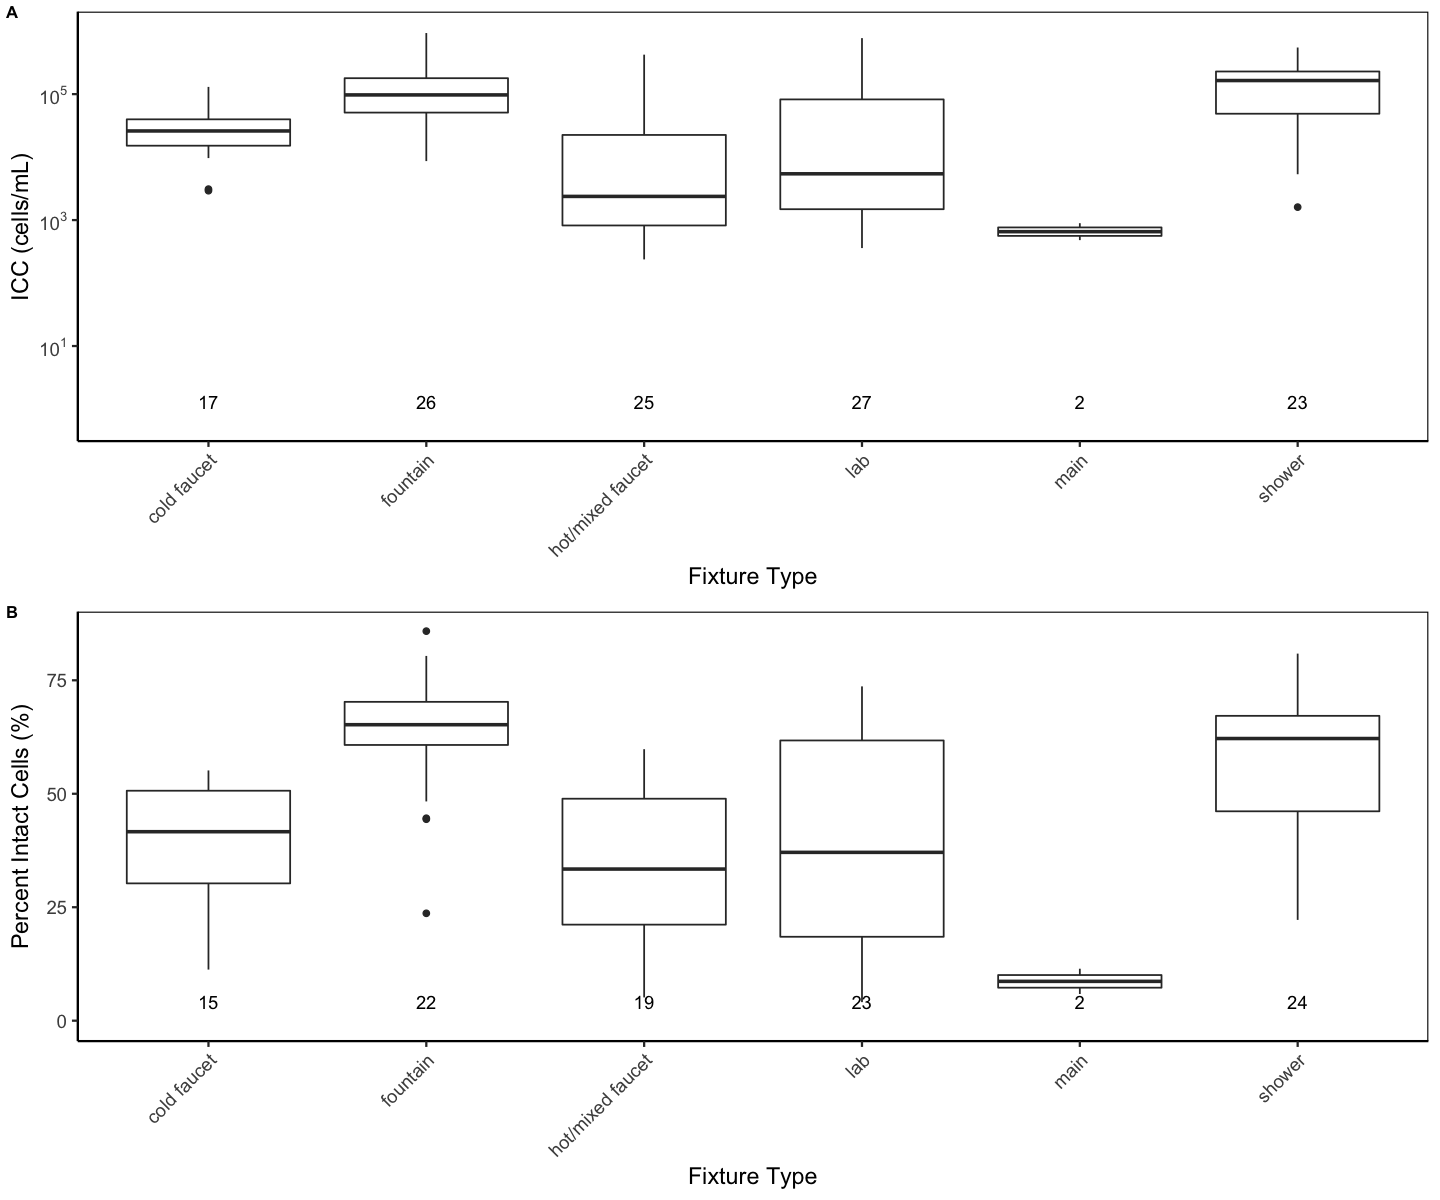

In [256]:
# plots by fixture type

options(repr.plot.width = 12, repr.plot.height = 10)
ICC_box <- ggplot(df_nocontrol, aes(x=fixture_type, y=ICC))+ #color based on hot_or_cold
geom_boxplot()+
xlab("Fixture Type")+
ylab("ICC (cells/mL)")+
scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)), limits=c(-1, 1e6))+
stat_summary(fun.data = give.n, geom = "text", vjust=-1, position = position_dodge(width = 0.75))+
theme(axis.text.x = element_text(angle = 45, hjust=1))+
theme( panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))

intact_box <- ggplot(df_nocontrol, aes(x=fixture_type, y=Percent_intact))+ #color based on hot_or_cold
geom_boxplot()+
xlab("Fixture Type")+
ylab("Percent Intact Cells (%)")+
stat_summary(fun.data = give.n, geom = "text", vjust=-1, position = position_dodge(width = 0.75))+
theme(axis.text.x = element_text(angle = 45, hjust=1))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))

fig_s<- ggarrange(ICC_box,intact_box, ncol=1, nrow=2, labels= c("A", "B"), font.label = list(size = 10, color = "black", face = "bold", family = NULL), legend = "right", common.legend = T, align = c("hv"))
fig_s
ggsave(paste0(fig_dir, 'FigureS2.jpeg'), width=12, height=10)

#stats tests
# kruskal.test(ICC ~ fixture_type, data = df_nocontrol_nomain) #yes, statistically significant differences in chlorine based on amoA presence
# wilcox.test(df_nocontrol_nomain$ICC[df_nocontrol_nomain$fixture_type== "shower"], df_nocontrol_nomain$ICC[df_nocontrol_nomain$fixture_type== "lab"], conf.level= 0.95)
# wilcox.test(df_nocontrol_nomain$ICC[df_nocontrol_nomain$fixture_type== "shower"], df_nocontrol_nomain$ICC[df_nocontrol_nomain$fixture_type== "fountain"], conf.level= 0.95)
# wilcox.test(df_nocontrol_nomain$ICC[df_nocontrol_nomain$fixture_type== "shower"], df_nocontrol_nomain$ICC[df_nocontrol_nomain$fixture_type== "cold faucet"], conf.level= 0.95)
# wilcox.test(df_nocontrol_nomain$ICC[df_nocontrol_nomain$fixture_type== "shower"], df_nocontrol_nomain$ICC[df_nocontrol_nomain$fixture_type== "hot/mixed faucet"], conf.level= 0.95)
# wilcox.test(df_nocontrol_nomain$ICC[df_nocontrol_nomain$fixture_type== "fountain"], df_nocontrol_nomain$ICC[df_nocontrol_nomain$fixture_type== "lab"], conf.level= 0.95)
# wilcox.test(df_nocontrol_nomain$ICC[df_nocontrol_nomain$fixture_type== "cold faucet"], df_nocontrol_nomain$ICC[df_nocontrol_nomain$fixture_type== "hot/mixed faucet"], conf.level= 0.95)

#geometric means
exp(mean(log(df_nocontrol_nomain$ICC[df_nocontrol_nomain$fixture_type== "shower"])))

ICC_fixture <- df_nocontrol_nomain %>% group_by(building, fixture_type, flush) %>% dplyr::summarise(gmean= exp(mean(log(ICC))))
ICC_fixture

                                                                                  

In [257]:
# plots by fixture type

#stats tests
# kruskal.test(ICC ~ fixture_type, data = df_nocontrol_nomain) #yes, statistically significant differences in chlorine based on amoA presence
wilcox.test(df_nocontrol$Percent_intact[(df_nocontrol_nomain$fixture_type== "fountain") & (df_nocontrol$flush== "pre")], df_nocontrol$Percent_intact[(df_nocontrol_nomain$fixture_type== "fountain") & (df_nocontrol_nomain$flush== "day after flush")], conf.level= 0.95)
wilcox.test(df_nocontrol$Percent_intact[(df_nocontrol_nomain$fixture_type== "lab") & (df_nocontrol$flush== "pre")], df_nocontrol$Percent_intact[(df_nocontrol_nomain$fixture_type== "lab") & (df_nocontrol_nomain$flush== "day after flush")], conf.level= 0.95)
wilcox.test(df_nocontrol$Percent_intact[(df_nocontrol_nomain$fixture_type== "cold faucet") & (df_nocontrol$flush== "pre")], df_nocontrol$Percent_intact[(df_nocontrol_nomain$fixture_type== "cold faucet") & (df_nocontrol_nomain$flush== "day after flush")], conf.level= 0.95)
wilcox.test(df_nocontrol$Percent_intact[(df_nocontrol_nomain$fixture_type== "hot/mixed faucet") & (df_nocontrol$flush== "pre")], df_nocontrol$Percent_intact[(df_nocontrol_nomain$fixture_type== "hot/mixed faucet") & (df_nocontrol_nomain$flush== "day after flush")], conf.level= 0.95)

# means
Intact_fixture <- df_nocontrol %>% group_by(building, fixture_type, flush) %>% dplyr::summarise(mean= mean(Percent_intact), n= n())
Intact_fixture

                                                                                  

Warning message in (df_nocontrol_nomain$fixture_type == "fountain") & (df_nocontrol$flush == :
“longer object length is not a multiple of shorter object length”



	Wilcoxon rank sum exact test

data:  df_nocontrol$Percent_intact[(df_nocontrol_nomain$fixture_type == "fountain") & (df_nocontrol$flush == "pre")] and df_nocontrol$Percent_intact[(df_nocontrol_nomain$fixture_type == "fountain") & (df_nocontrol_nomain$flush == "day after flush")]
W = 60, p-value = 0.135
alternative hypothesis: true location shift is not equal to 0


Warning message in (df_nocontrol_nomain$fixture_type == "lab") & (df_nocontrol$flush == :
“longer object length is not a multiple of shorter object length”



	Wilcoxon rank sum exact test

data:  df_nocontrol$Percent_intact[(df_nocontrol_nomain$fixture_type == "lab") & (df_nocontrol$flush == "pre")] and df_nocontrol$Percent_intact[(df_nocontrol_nomain$fixture_type == "lab") & (df_nocontrol_nomain$flush == "day after flush")]
W = 88, p-value = 0.0001474
alternative hypothesis: true location shift is not equal to 0


Warning message in (df_nocontrol_nomain$fixture_type == "cold faucet") & (df_nocontrol$flush == :
“longer object length is not a multiple of shorter object length”



	Wilcoxon rank sum exact test

data:  df_nocontrol$Percent_intact[(df_nocontrol_nomain$fixture_type == "cold faucet") & (df_nocontrol$flush == "pre")] and df_nocontrol$Percent_intact[(df_nocontrol_nomain$fixture_type == "cold faucet") & (df_nocontrol_nomain$flush == "day after flush")]
W = 21, p-value = 0.05128
alternative hypothesis: true location shift is not equal to 0


Warning message in (df_nocontrol_nomain$fixture_type == "hot/mixed faucet") & (df_nocontrol$flush == :
“longer object length is not a multiple of shorter object length”



	Wilcoxon rank sum exact test

data:  df_nocontrol$Percent_intact[(df_nocontrol_nomain$fixture_type == "hot/mixed faucet") & (df_nocontrol$flush == "pre")] and df_nocontrol$Percent_intact[(df_nocontrol_nomain$fixture_type == "hot/mixed faucet") & (df_nocontrol_nomain$flush == "day after flush")]
W = 72, p-value = 0.002211
alternative hypothesis: true location shift is not equal to 0


`summarise()` has grouped output by 'building', 'fixture_type'. You can
override using the `.groups` argument.


building,fixture_type,flush,mean,n
<ord>,<chr>,<fct>,<dbl>,<int>
D,cold faucet,pre,38.03429,7
D,cold faucet,post,NA,2
D,cold faucet,day after flush,17.15000,2
D,fountain,pre,63.14000,10
D,fountain,post,NA,4
D,fountain,day after flush,61.58750,4
D,hot/mixed faucet,pre,41.94923,13
D,hot/mixed faucet,post,NA,6
D,hot/mixed faucet,day after flush,17.26500,6


In [258]:
#look at percentage of samples above regulation limits

# Cu_above_reg = na.omit(df_nocontrol$Cu.ppb >= Cu.ppb_reg)
# Cu_above_reg_percent= sum(Cu_above_reg)/length(Cu_above_reg)*100
# Cu_above_reg_percent

### ICC vs physicochemical parameters

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 16 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 16 rows containing missing values (geom_point).”


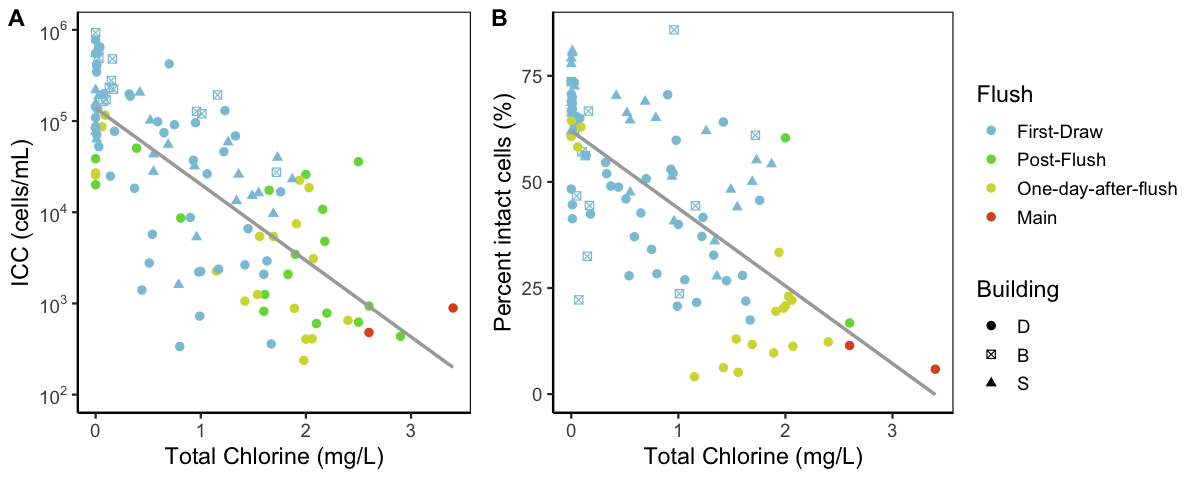

In [259]:
options(repr.plot.width = 10, repr.plot.height = 4)

icc <- ggplot(df_nocontrol)+
geom_point(aes(x=cl_total, y=ICC, color= flush, shape= building), size=2)+
stat_smooth(aes(x=cl_total, y=ICC), method="lm", se=FALSE, color= "#a9a9a9")+
# aes(color=tap_code)+
    scale_shape_manual(values=c(19, 7,17),
                       name="Building",
                       labels=c("D", "B", "S"))+
    scale_color_manual(values= c("#89C5DA", "#74D944", "#D3D93E","#DA5724"), name="Flush",
                       labels=c("First-Draw", "Post-Flush", "One-day-after-flush", "Main"))+
xlab('Total Chlorine (mg/L)')+
ylab('ICC (cells/mL)')+
scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)), limits=c(1e2, 1e6))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))

# df_nocontrol[is.na(df_nocontrol$hot_or_cold),]
intact <- ggplot(df_nocontrol)+
geom_point(aes(x=cl_total, y=Percent_intact, color= flush, shape= building), size=2)+
stat_smooth(aes(x=cl_total, y=Percent_intact), method="lm", se=FALSE, color= "#a9a9a9")+
scale_shape_manual(values=c(19, 7,17),
                       name="Building",
                       labels=c("D", "B", "S"))+
scale_color_manual(values= c("#89C5DA", "#74D944", "#D3D93E","#DA5724"),name="Flush",
                       labels=c("First-Draw", "Post-Flush", "One-day-after-flush", "Main"))+
xlab('Total Chlorine (mg/L)')+
ylab('Percent intact cells (%)')+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))

ggarrange(icc, intact, labels= c('A', 'B'), common.legend= TRUE, legend= "right")
ggsave(paste0(fig_dir, 'Figure2.jpeg'), width=10, height=4)


In [260]:
df_cor <- df_nocontrol %>% select(cl_total, ICC, Percent_intact)
cor(df_cor, method="kendall", use="pairwise") 

res1 <- cor.mtest(df_cor, method ="kendall", use="pairwise", conf.level = .95)
res1$p


,cl_total,ICC,Percent_intact
cl_total,1.0000000,-0.5211581,-0.5246734
ICC,-0.5211581,1.0000000,0.4450549
Percent_intact,-0.5246734,0.4450549,1.0000000


,cl_total,ICC,Percent_intact
cl_total,0.000000e+00,4.576443e-17,4.051450e-15
ICC,4.576443e-17,0.000000e+00,1.715356e-11
Percent_intact,4.051450e-15,1.715356e-11,0.000000e+00


### Boxplot summarizing flushing impact

In [261]:
#create df with the averages of the DMain values from two days of sampling

main <- filter(data_all, tap_code== "DMain")
main

exp(mean(log(main$ICC)))
exp(mean(log(main$TCC)))
mean(main$cl_total)

sample_id,sample_name,include,qubit_ngul,date,date_cat,flush,date_cat_main,tap_code,pre_post,⋯,avg_gc_MAC,avg_gc_mip,avg_gc_Ps,positivity_AmoA,positivity_MAC,positivity_mip,positivity_Ps,before_after,date_formal,fixture_type
<chr>,<chr>,<chr>,<chr>,<date>,<ord>,<fct>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<ord>,<chr>
DMain_061120_main,DMain_061120_main,Y,toolow,2020-06-11,6/11_pre,main,6/11_main,DMain,main,⋯,NaN,NaN,NaN,0 reps,0 reps,0 reps,0 reps,after,June 11 First-Draw,main
DMain_071420_main,DMain_071420_main,Y,toolow,2020-07-14,7/14_pre,main,7/14_main,DMain,main,⋯,NaN,0.9026271,NaN,0 reps,0 reps,<LoD,0 reps,after,July 14 First-Draw,main


[1] 654.647

[1] 7979.045

[1] 3

In [262]:
#plot davis values throughout study

options(repr.plot.width = 9, repr.plot.height = 6)
a<- data_all_melt %>% drop_na(date_cat) %>% filter(date_cat != "5/14_post") %>% filter(assay== "cl_total") %>% filter(building == "D") %>% filter(tap_code != "DMain")

fig_3a <- ggplot(a, aes(x=date_formal, y=value))+
stat_summary(fun.data= give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_boxplot(lwd=0.75, aes(fill=flush))+
scale_fill_viridis_d(begin = 0.35, end = 0.8, option = "D", alpha=0.3, labels=c("First Draw", "Flushed", "Day After Flush"), name= "Flush")+
guides(fill=guide_legend(ncol = 1, title="Flush"))+    
ggnewscale::new_scale_fill()+
geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_viridis_d(option="G")+
scale_fill_viridis_d(begin = 0, end = 0.9, name= "tap_code", alpha=0.8, option = "H")+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
geom_line(aes(group=tap_code), size=0.3, linetype="dotted")+
xlab('')+
ylab('Total Chlorine\n(mg/L)')+
geom_hline(yintercept= mean(main$cl_total), linetype= "dashed", size= 1, color= "black")+
guides(fill=guide_legend(ncol = 1, title="Fixture ID"))+
 geom_vline(xintercept= 3.5)+
              geom_vline(xintercept= 6.5)+
theme(axis.text.x = element_text(angle = 45, hjust=1))+
theme(legend.position= "right", 
      panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))

# ggsave(paste0(fig_dir, '101120_total_chlorine_cold_nofountains_Davis.png'), width=8, height=4)

In [263]:
#plot subset of davis values throughout study

options(repr.plot.width = 9, repr.plot.height = 6)
a<- data_all_melt %>% drop_na(date_cat) %>% filter(date_cat != "5/14_post") %>% filter(assay== "cl_total") %>% filter(building == "D") %>% 
filter(tap_code != "DMain")%>%filter(tap_code != "D5H")#%>%filter(tap_code != "D4L") #%>% filter(type != "fountain")


fig_3a_nof <- ggplot(a, aes(x=date_formal, y=value))+
geom_boxplot(lwd=0.75, aes(fill=flush))+
scale_fill_viridis_d(begin = 0.35, end = 0.8, option = "D", alpha=0.3, labels=c("First Draw", "Flushed", "Day After Flush"))+
    ggnewscale::new_scale_fill()+
guides(fill=guide_legend(ncol = 1, title="Flush"))+
stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_viridis_d(option="G")+
scale_fill_viridis_d(begin = 0, end = 0.9, name= "tap_code", alpha=0.8, option = "H")+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
geom_line(aes(group=tap_code), size=0.3, linetype="dotted")+
xlab('Flushing Event')+
ylab('Total Chlorine\n(mg/L)')+
geom_hline(yintercept= mean(main$cl_total), linetype= "dashed", size= 1, color= "black")+
guides(fill=guide_legend(ncol = 1, title="Fixture ID"))+
 geom_vline(xintercept= 3.5)+
              geom_vline(xintercept= 6.5)+
theme(axis.text.x = element_text(angle = 45, hjust=1))+
theme(legend.position= "right", 
      panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))

# fig_3a_nof
# ggsave(paste0(fig_dir, '101120_total_chlorine_cold_nofountains_Davis.png'), width=8, height=4)

In [264]:
#test chlorine differences 
wilcox.test(a$value[(a$date_cat== "5/14_pre")], a$value[(a$date_cat== "5/21_pre")], conf.level= 0.95)#not different
wilcox.test(a$value[(a$date_cat== "5/21_pre")], a$value[(a$date_cat== "6/4_pre")], conf.level= 0.95)#not different
wilcox.test(a$value[(a$date_cat== "6/4_pre")], a$value[(a$date_cat== "6/4_post")], conf.level= 0.95) #different
wilcox.test(a$value[(a$date_cat== "6/4_post")], a$value[(a$date_cat== "6/5_pre")], conf.level= 0.95) #not different
wilcox.test(a$value[(a$date_cat== "6/5_pre")], a$value[(a$date_cat== "6/11_pre")], conf.level= 0.95) #different
wilcox.test(a$value[(a$date_cat== "6/11_pre")], a$value[(a$date_cat== "6/11_post")], conf.level= 0.95) #different
wilcox.test(a$value[(a$date_cat== "6/11_post")], a$value[(a$date_cat== "6/12_pre")], conf.level= 0.95) #not different
wilcox.test(a$value[(a$date_cat== "6/12_pre")], a$value[(a$date_cat== "7/14_pre")], conf.level= 0.95) #different

kruskal.test(value ~ date_cat, data = a) #different on the whole

a$before_after <- NA #create column for the dates before 6/4 flush and after 6/4 flush
a$before_after[a$date_cat == "5/14_pre" | a$date_cat == "5/21_pre"| a$date_cat == "6/4_pre"] <- "before"
a$before_after[a$date_cat == "6/4_post" | a$date_cat == "6/5_pre"| a$date_cat == "6/11_pre"| a$date_cat == "6/11_post"| a$date_cat == "6/12_pre"| a$date_cat == "7/14_pre"] <- "after"
kruskal.test(value ~ date_cat, data = a[a$before_after == "before",]) #p=0.9
wilcox.test(a$value[(a$before_after== "before")], a$value[(a$before_after== "after")], conf.level= 0.95) #different


Warning message in wilcox.test.default(a$value[(a$date_cat == "5/14_pre")], a$value[(a$date_cat == :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  a$value[(a$date_cat == "5/14_pre")] and a$value[(a$date_cat == "5/21_pre")]
W = 29, p-value = 0.7908
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(a$value[(a$date_cat == "5/21_pre")], a$value[(a$date_cat == :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  a$value[(a$date_cat == "5/21_pre")] and a$value[(a$date_cat == "6/4_pre")]
W = 31.5, p-value = 1
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(a$value[(a$date_cat == "6/4_pre")], a$value[(a$date_cat == :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  a$value[(a$date_cat == "6/4_pre")] and a$value[(a$date_cat == "6/4_post")]
W = 10.5, p-value = 0.02731
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(a$value[(a$date_cat == "6/4_post")], a$value[(a$date_cat == :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  a$value[(a$date_cat == "6/4_post")] and a$value[(a$date_cat == "6/5_pre")]
W = 43.5, p-value = 0.2476
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(a$value[(a$date_cat == "6/5_pre")], a$value[(a$date_cat == :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  a$value[(a$date_cat == "6/5_pre")] and a$value[(a$date_cat == "6/11_pre")]
W = 48.5, p-value = 0.09265
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(a$value[(a$date_cat == "6/11_pre")], a$value[(a$date_cat == :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  a$value[(a$date_cat == "6/11_pre")] and a$value[(a$date_cat == "6/11_post")]
W = 12.5, p-value = 0.04584
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(a$value[(a$date_cat == "6/11_post")], a$value[(a$date_cat == :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  a$value[(a$date_cat == "6/11_post")] and a$value[(a$date_cat == "6/12_pre")]
W = 36.5, p-value = 0.6742
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  a$value[(a$date_cat == "6/12_pre")] and a$value[(a$date_cat == "7/14_pre")]
W = 44, p-value = 0.2345
alternative hypothesis: true location shift is not equal to 0



	Kruskal-Wallis rank sum test

data:  value by date_cat
Kruskal-Wallis chi-squared = 21.451, df = 8, p-value = 0.006042



	Kruskal-Wallis rank sum test

data:  value by date_cat
Kruskal-Wallis chi-squared = 0.19124, df = 2, p-value = 0.9088


Warning message in wilcox.test.default(a$value[(a$before_after == "before")], a$value[(a$before_after == :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  a$value[(a$before_after == "before")] and a$value[(a$before_after == "after")]
W = 258.5, p-value = 0.0001492
alternative hypothesis: true location shift is not equal to 0


In [265]:
#plot davis values throughout study

options(repr.plot.width = 9, repr.plot.height = 6)
a<- data_all_melt %>% drop_na(date_cat)%>% filter(date_cat != "5/14_post") %>% filter(assay== "DO") %>% filter(building == "D") %>% filter(tap_code != "DMain")
# a<-a[(a$assay== "cl_total")& (!is.na(a$assay)),]
# a<-a[(a$type!= "fountain")& (!is.na(a$type)),]

fig_3c <- ggplot(a, aes(x=date_formal, y=value))+
stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_boxplot(lwd=0.75, aes(fill=flush))+
scale_fill_viridis_d(begin = 0.35, end = 0.8, option = "D", alpha=0.3, labels=c("First Draw", "Flushed", "Day After Flush"), name= "Flush")+
    ggnewscale::new_scale_fill()+
# stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_viridis_d(option="G")+
scale_fill_viridis_d(begin = 0, end = 0.9,  alpha=0.8, option = "H", name= "Fixture ID")+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
geom_line(aes(group=tap_code), size=0.3, linetype="dotted")+
xlab('')+
ylab('dissolved oxygen\n(mg/L)')+
geom_hline(yintercept= mean(main$DO), linetype= "dashed", size= 1, color= "black")+

theme(axis.text.x = element_text(angle = 45, hjust=1))+
theme(legend.position= "right", 
      panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
# ggsave(paste0(fig_dir, '101120_total_chlorine_cold_nofountains_Davis.png'), width=8, height=4)

In [266]:
#plot davis values throughout study

options(repr.plot.width = 9, repr.plot.height = 6)
a<- data_all_melt %>% drop_na(date_cat)%>% filter(date_cat != "5/14_post") %>% filter(assay== "pH") %>% filter(building == "D") %>% filter(tap_code != "DMain")
# a<-a[(a$assay== "cl_total")& (!is.na(a$assay)),]
# a<-a[(a$type!= "fountain")& (!is.na(a$type)),]

fig_3i <- ggplot(a, aes(x=date_formal, y=value))+
stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_boxplot(lwd=0.75, aes(fill=flush))+
scale_fill_viridis_d(begin = 0.35, end = 0.8, option = "D", alpha=0.3, labels=c("First Draw", "Flushed", "Day After Flush"))+
    ggnewscale::new_scale_fill()+
# stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_viridis_d(option="G")+
scale_fill_viridis_d(begin = 0, end = 0.9, name= "Fixture ID", alpha=0.8, option = "H")+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
geom_line(aes(group=tap_code), size=0.3, linetype="dotted")+
xlab('')+
ylab('pH')+
geom_hline(yintercept= mean(main$pH), linetype= "dashed", size= 1, color= "black")+
guides(fill=guide_legend(ncol = 1))+
theme(axis.text.x = element_text(angle = 45, hjust=1))+
theme(legend.position= "right", 
      panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
# ggsave(paste0(fig_dir, '101120_total_chlorine_cold_nofountains_Davis.png'), width=8, height=4)

In [267]:
#plot davis values throughout study

options(repr.plot.width = 9, repr.plot.height = 6)
a<- data_all_melt %>% drop_na(date_cat)%>% filter(date_cat != "5/14_post") %>% filter(assay== "temp") %>% filter(building == "D") %>% filter(tap_code != "DMain")
# a<-a[(a$assay== "cl_total")& (!is.na(a$assay)),]
# a<-a[(a$type!= "fountain")& (!is.na(a$type)),]

fig_3j <- ggplot(a, aes(x=date_formal, y=value))+
stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_boxplot(lwd=0.75, aes(fill=flush))+
scale_fill_viridis_d(begin = 0.35, end = 0.8, option = "D", alpha=0.3, labels=c("First Draw", "Flushed", "Day After Flush"))+
    ggnewscale::new_scale_fill()+
# stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_viridis_d(option="G")+
scale_fill_viridis_d(begin = 0, end = 0.9, name= "tap_code", alpha=0.8, option = "H")+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
geom_line(aes(group=tap_code), size=0.3, linetype="dotted")+
xlab('')+
ylab('Temperature (C)')+
geom_hline(yintercept= mean(main$temp), linetype= "dashed", size= 1, color= "black")+
guides(fill=guide_legend(ncol = 1))+
theme(axis.text.x = element_text(angle = 45, hjust=1))+
theme(legend.position= "right", 
      panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
# ggsave(paste0(fig_dir, '101120_total_chlorine_cold_nofountains_Davis.png'), width=8, height=4)

In [268]:
#plot davis values throughout study

options(repr.plot.width = 9, repr.plot.height = 6)
a<- data_all_melt %>% drop_na(date_cat)%>% filter(date_cat != "5/14_post") %>% filter(assay== "conductivity") %>% filter(building == "D") %>% filter(tap_code != "DMain")
# a<-a[(a$assay== "cl_total")& (!is.na(a$assay)),]
# a<-a[(a$type!= "fountain")& (!is.na(a$type)),]

fig_3d <- ggplot(a, aes(x=date_formal, y=value))+
stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_boxplot(lwd=0.75, aes(fill=flush))+
scale_fill_viridis_d(begin = 0.35, end = 0.8, option = "D", alpha=0.3, labels=c("First Draw", "Flushed", "Day After Flush"))+
    ggnewscale::new_scale_fill()+
# stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_viridis_d(option="G")+
scale_fill_viridis_d(begin = 0, end = 0.9, name= "tap_code", alpha=0.8, option = "H")+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
geom_line(aes(group=tap_code), size=0.3, linetype="dotted")+
xlab('')+
ylab('conductivity')+
geom_hline(yintercept= mean(main$conductivity), linetype= "dashed", size= 1, color= "black")+
guides(fill=guide_legend(ncol = 1))+
theme(axis.text.x = element_text(angle = 45, hjust=1))+
theme(legend.position= "right", 
      panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))

# ggsave(paste0(fig_dir, '101120_total_chlorine_cold_nofountains_Davis.png'), width=8, height=4)

In [269]:
#plot davis values throughout study

options(repr.plot.width = 9, repr.plot.height = 6)
a<- data_all_melt %>% drop_na(date_cat)%>% filter(date_cat != "5/14_post") %>% filter(assay== "Pb") %>% filter(building == "D") %>% filter(tap_code != "DMain")
# a<-a[(a$assay== "cl_total")& (!is.na(a$assay)),]
# a<-a[(a$type!= "fountain")& (!is.na(a$type)),]

fig_3e <- ggplot(a, aes(x=date_formal, y=value))+
stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_boxplot(lwd=0.75, aes(fill=flush))+
scale_fill_viridis_d(begin = 0.35, end = 0.8, option = "D", alpha=0.3, labels=c("First Draw", "Flushed", "Day After Flush"))+
    ggnewscale::new_scale_fill()+
# stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_viridis_d(option="G")+
scale_fill_viridis_d(begin = 0, end = 0.9, name= "tap_code", alpha=0.8, option = "H")+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
geom_line(aes(group=tap_code), size=0.3, linetype="dotted")+
xlab('')+
ylab('Pb (ppb)')+
geom_hline(yintercept= mean(main$Pb), linetype= "dashed", size= 1, color= "black")+
guides(fill=guide_legend(ncol = 1))+
theme(axis.text.x = element_text(angle = 45, hjust=1))+
theme(legend.position= "right", 
      panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
# ggsave(paste0(fig_dir, '101120_total_chlorine_cold_nofountains_Davis.png'), width=8, height=4)

In [270]:
#plot davis values throughout study

options(repr.plot.width = 9, repr.plot.height = 6)
a<- data_all_melt %>% drop_na(date_cat)%>% filter(date_cat != "5/14_post") %>% filter(assay== "nitrate_avg") %>% filter(building == "D") %>% filter(tap_code != "DMain")
# a<-a[(a$assay== "cl_total")& (!is.na(a$assay)),]
# a<-a[(a$type!= "fountain")& (!is.na(a$type)),]

fig_3f <- ggplot(a, aes(x=date_formal, y=value))+
stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_boxplot(lwd=0.75, aes(fill=flush))+
scale_fill_viridis_d(begin = 0.35, end = 0.8, option = "D", alpha=0.3, labels=c("First Draw", "Flushed", "Day After Flush"))+
    ggnewscale::new_scale_fill()+
geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_viridis_d(option="G")+
scale_fill_viridis_d(begin = 0, end = 0.9, name= "tap_code", alpha=0.8, option = "H")+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
geom_line(aes(group=tap_code), size=0.3, linetype="dotted")+
xlab('')+
ylab('Nitrate (mg/L)')+
geom_hline(yintercept= mean(main$nitrate_avg), linetype= "dashed", size= 1, color= "black")+
guides(fill=guide_legend(ncol = 1))+
theme(axis.text.x = element_text(angle = 45, hjust=1))+
theme(legend.position= "right", 
      panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))

# ggsave(paste0(fig_dir, '101120_total_chlorine_cold_nofountains_Davis.png'), width=8, height=4)

In [271]:
#plot davis values throughout study

options(repr.plot.width = 9, repr.plot.height = 6)
a<- data_all_melt %>% drop_na(date_cat)%>% filter(date_cat != "5/14_post") %>% filter(assay== "Mn") %>% filter(building == "D") %>% filter(tap_code != "DMain")
# a<-a[(a$assay== "cl_total")& (!is.na(a$assay)),]
# a<-a[(a$type!= "fountain")& (!is.na(a$type)),]

fig_3g <- ggplot(a, aes(x=date_formal, y=value))+
stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_boxplot(lwd=0.75, aes(fill=flush))+
scale_fill_viridis_d(begin = 0.35, end = 0.8, option = "D", alpha=0.3, labels=c("First Draw", "Flushed", "Day After Flush"))+
    ggnewscale::new_scale_fill()+
geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
scale_fill_viridis_d(begin = 0, end = 0.9, name= "tap_code", alpha=0.8, option = "H")+
geom_line(aes(group=tap_code), size=0.3, linetype="dotted")+
xlab('')+
ylab('Mn (ppb)')+
geom_hline(yintercept= mean(main$Mn), linetype= "dashed", size= 1, color= "black")+
guides(fill=guide_legend(ncol = 1))+
theme(axis.text.x = element_text(angle = 45, hjust=1))+
theme(legend.position= "right", 
      panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
# ggsave(paste0(fig_dir, '101120_total_chlorine_cold_nofountains_Davis.png'), width=8, height=4)

In [272]:
#plot davis values throughout study

options(repr.plot.width = 9, repr.plot.height = 6)
a<- data_all_melt %>% drop_na(date_cat)%>% filter(date_cat != "5/14_post") %>% filter(assay== "Fe") %>% filter(building == "D") %>% filter(tap_code != "DMain")
# a<-a[(a$assay== "cl_total")& (!is.na(a$assay)),]
# a<-a[(a$type!= "fountain")& (!is.na(a$type)),]

fig_3h <- ggplot(a, aes(x=date_formal, y=value))+
stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_boxplot(lwd=0.75, aes(fill=flush))+
scale_fill_viridis_d(begin = 0.35, end = 0.8, option = "D", alpha=0.3, labels=c("First Draw", "Flushed", "Day After Flush"))+
    ggnewscale::new_scale_fill()+
geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_viridis_d(option="G")+
scale_fill_viridis_d(begin = 0, end = 0.9, name= "tap_code", alpha=0.8, option = "H")+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
geom_line(aes(group=tap_code), size=0.3, linetype="dotted")+
xlab('')+
ylab('Fe (ppb)')+
geom_hline(yintercept= mean(main$Fe), linetype= "dashed", size= 1, color= "black")+
guides(fill=guide_legend(ncol = 1))+
theme(axis.text.x = element_text(angle = 45, hjust=1))+
theme(legend.position= "right", 
      panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
# ggsave(paste0(fig_dir, '101120_total_chlorine_cold_nofountains_Davis.png'), width=8, height=4)

In [273]:
#plot davis values throughout study

options(repr.plot.width = 9, repr.plot.height = 6)
a<- data_all_melt %>% drop_na(date_cat) %>% filter(date_cat != "5/14_post")%>% filter(assay== "ICC") %>% filter(building == "D") %>% filter(tap_code != "DMain")
# a<-a[(a$assay== "cl_total")& (!is.na(a$assay)),]
# a<-a[(a$type!= "fountain")& (!is.na(a$type)),]

fig_3b <- ggplot(a, aes(x=date_formal, y=value))+
geom_boxplot(lwd=0.75, aes(fill=flush))+
stat_summary(fun.data = give.n, geom = "text", vjust=-20, position = position_dodge(width = 0.75))+
scale_fill_viridis_d(begin = 0.35, end = 0.8, option = "D", alpha=0.3, labels=c("First Draw", "Flushed", "Day After Flush"), name= "Flush")+
    ggnewscale::new_scale_fill()+
geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_viridis_d(option="G")+
scale_fill_viridis_d(begin = 0, end = 0.9, name= "Fixture ID", alpha=0.8, option = "H")+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
geom_line(aes(group=tap_code), size=0.3, linetype="dotted")+
xlab('')+
ylab('ICC (cells/mL)')+
scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x))) +
              coord_cartesian(ylim=c(5e1,1e6))+
geom_hline(yintercept= exp(mean(log(main$ICC))), linetype= "dashed", size= 1, color= "black")+
              geom_vline(xintercept= 3.5)+
              geom_vline(xintercept= 6.5)+
guides(fill=guide_legend(ncol = 1, title="Fixture ID"))+
theme(axis.text.x = element_text(angle = 45, hjust=1))+
theme(legend.position= "right", 
      panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
# ggsave(paste0(fig_dir, '101120_total_chlorine_cold_nofountains_Davis.png'), width=8, height=4)
            

In [274]:
#test cell count differences 
wilcox.test(a$value[(a$date_cat== "6/4_pre")], a$value[(a$date_cat== "6/4_post")], conf.level= 0.95) #different
wilcox.test(a$value[(a$date_cat== "6/4_post")], a$value[(a$date_cat== "6/5_pre")], conf.level= 0.95) #not different
wilcox.test(a$value[(a$date_cat== "6/5_pre")], a$value[(a$date_cat== "6/11_pre")], conf.level= 0.95) #not different
wilcox.test(a$value[(a$date_cat== "6/11_pre")], a$value[(a$date_cat== "6/11_post")], conf.level= 0.95) #not different
wilcox.test(a$value[(a$date_cat== "6/11_post")], a$value[(a$date_cat== "6/12_pre")], conf.level= 0.95) #not different

wilcox.test(a$value[(a$date_cat== "6/4_post")], a$value[(a$date_cat== "6/11_pre")], conf.level= 0.95) #different

kruskal.test(value ~ date_cat, data = a) #different on the whole

a$before_after <- NA #create column for the dates before 6/4 flush and after 6/4 flush
a$before_after[a$date_cat == "5/14_pre" | a$date_cat == "5/21_pre"| a$date_cat == "6/4_pre"] <- "before"
a$before_after[a$date_cat == "6/4_post" | a$date_cat == "6/5_pre"| a$date_cat == "6/11_pre"| a$date_cat == "6/11_post"| a$date_cat == "6/12_pre"| a$date_cat == "7/14_pre"] <- "after"
wilcox.test(a$value[(a$before_after== "before")], a$value[(a$before_after== "after")], conf.level= 0.95) #different!

kruskal.test(value ~ date_cat, data = a[a$before_after== "before",]) #not different



	Wilcoxon rank sum exact test

data:  a$value[(a$date_cat == "6/4_pre")] and a$value[(a$date_cat == "6/4_post")]
W = 71, p-value = 0.005636
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  a$value[(a$date_cat == "6/4_post")] and a$value[(a$date_cat == "6/5_pre")]
W = 38, p-value = 0.8633
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  a$value[(a$date_cat == "6/5_pre")] and a$value[(a$date_cat == "6/11_pre")]
W = 22, p-value = 0.1135
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  a$value[(a$date_cat == "6/11_pre")] and a$value[(a$date_cat == "6/11_post")]
W = 62, p-value = 0.06253
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  a$value[(a$date_cat == "6/11_post")] and a$value[(a$date_cat == "6/12_pre")]
W = 44, p-value = 0.7962
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  a$value[(a$date_cat == "6/4_post")] and a$value[(a$date_cat == "6/11_pre")]
W = 16, p-value = 0.03147
alternative hypothesis: true location shift is not equal to 0



	Kruskal-Wallis rank sum test

data:  value by date_cat
Kruskal-Wallis chi-squared = 23.588, df = 8, p-value = 0.002686



	Wilcoxon rank sum test with continuity correction

data:  a$value[(a$before_after == "before")] and a$value[(a$before_after == "after")]
W = 1154, p-value = 2.11e-05
alternative hypothesis: true location shift is not equal to 0



	Kruskal-Wallis rank sum test

data:  value by date_cat
Kruskal-Wallis chi-squared = 0.098765, df = 2, p-value = 0.9518


In [275]:
#subset fixtures out that had evidence of use

options(repr.plot.width = 9, repr.plot.height = 6)
a_nouse<- data_all_melt %>% drop_na(date_cat) %>% filter(date_cat != "5/14_post")%>% filter(assay== "ICC") %>% 
filter(building == "D") %>% filter(tap_code != "DMain")%>%filter(tap_code != "D5H") #%>%filter(tap_code != "D4L") #%>% filter(type != "fountain")

#test cell count differences 
wilcox.test(a$value[(a$date_cat== "6/4_pre")], a$value[(a$date_cat== "6/4_post")], conf.level= 0.95) #different
wilcox.test(a$value[(a$date_cat== "6/4_post")], a$value[(a$date_cat== "6/5_pre")], conf.level= 0.95) #not different
wilcox.test(a$value[(a$date_cat== "6/5_pre")], a$value[(a$date_cat== "6/11_pre")], conf.level= 0.95) #different
wilcox.test(a$value[(a$date_cat== "6/11_pre")], a$value[(a$date_cat== "6/11_post")], conf.level= 0.95) #different
wilcox.test(a$value[(a$date_cat== "6/11_post")], a$value[(a$date_cat== "6/12_pre")], conf.level= 0.95) #not different
wilcox.test(a$value[(a$date_cat== "6/4_post")], a$value[(a$date_cat== "6/11_pre")], conf.level= 0.95) #different


kruskal.test(value ~ date_cat, data = a) #different on the whole

a$before_after <- NA #create column for the dates before 6/4 flush and after 6/4 flush
a$before_after[a$date_cat == "5/14_pre" | a$date_cat == "5/21_pre"| a$date_cat == "6/4_pre"] <- "before"
a$before_after[a$date_cat == "6/4_post" | a$date_cat == "6/5_pre"| a$date_cat == "6/11_pre"| a$date_cat == "6/11_post"| a$date_cat == "6/12_pre"| a$date_cat == "7/14_pre"] <- "after"
wilcox.test(a$value[(a$before_after== "before")], a$value[(a$before_after== "after")], conf.level= 0.95) #different!



	Wilcoxon rank sum exact test

data:  a$value[(a$date_cat == "6/4_pre")] and a$value[(a$date_cat == "6/4_post")]
W = 71, p-value = 0.005636
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  a$value[(a$date_cat == "6/4_post")] and a$value[(a$date_cat == "6/5_pre")]
W = 38, p-value = 0.8633
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  a$value[(a$date_cat == "6/5_pre")] and a$value[(a$date_cat == "6/11_pre")]
W = 22, p-value = 0.1135
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  a$value[(a$date_cat == "6/11_pre")] and a$value[(a$date_cat == "6/11_post")]
W = 62, p-value = 0.06253
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  a$value[(a$date_cat == "6/11_post")] and a$value[(a$date_cat == "6/12_pre")]
W = 44, p-value = 0.7962
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  a$value[(a$date_cat == "6/4_post")] and a$value[(a$date_cat == "6/11_pre")]
W = 16, p-value = 0.03147
alternative hypothesis: true location shift is not equal to 0



	Kruskal-Wallis rank sum test

data:  value by date_cat
Kruskal-Wallis chi-squared = 23.588, df = 8, p-value = 0.002686



	Wilcoxon rank sum test with continuity correction

data:  a$value[(a$before_after == "before")] and a$value[(a$before_after == "after")]
W = 1154, p-value = 2.11e-05
alternative hypothesis: true location shift is not equal to 0


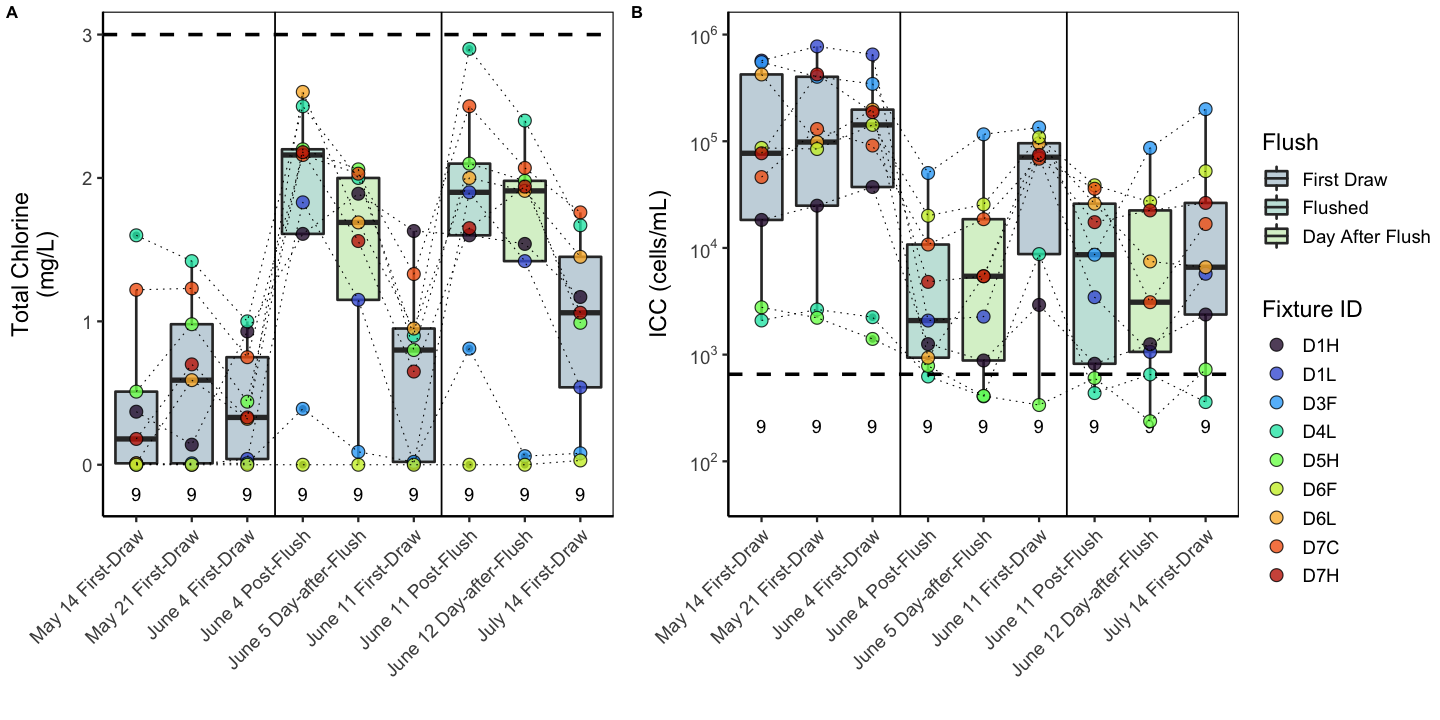

In [276]:
#arrange plots for flushing figure together
options(repr.plot.width = 12, repr.plot.height = 6)
fig_2<- ggarrange(fig_3a,fig_3b, ncol=2, nrow=1, labels= c("A", "B"), font.label = list(size = 10, color = "black", face = "bold", family = NULL), legend = "right", common.legend = T, align = c("hv"))
fig_2
ggsave(paste0(fig_dir, 'Figure3.jpeg'), width=12, height=6)

Warning message:
“Removed 2 rows containing non-finite values (new_stat_summary).”
Warning message:
“Removed 2 rows containing non-finite values (new_stat_boxplot).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 9 rows containing non-finite values (new_stat_summary).”
Warning message:
“Removed 9 rows containing non-finite values (new_stat_boxplot).”
Warning message:
“Removed 9 rows containing missing values (geom_point).”


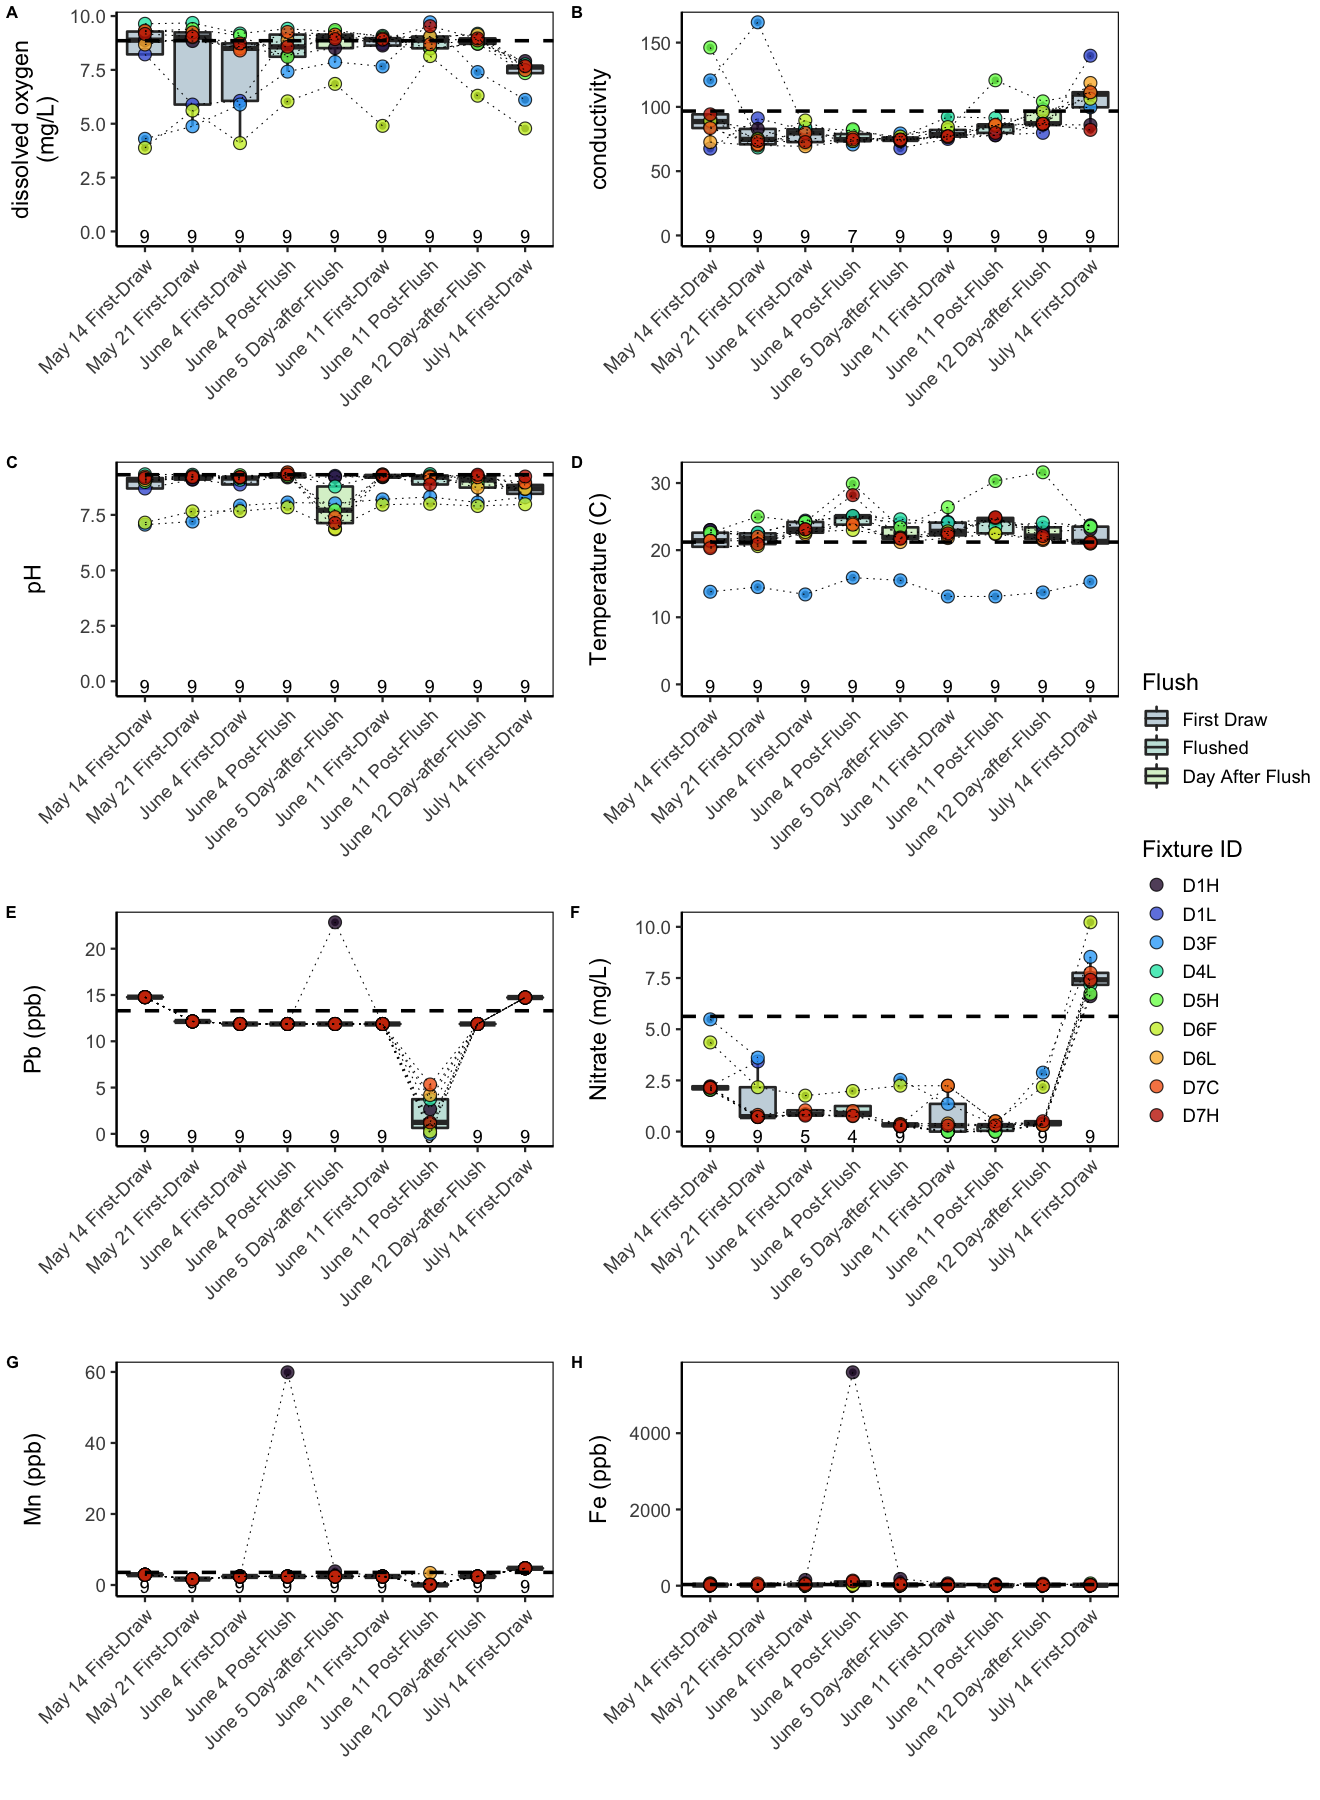

In [277]:
#arrange plots for flushing figure together
options(repr.plot.width = 11, repr.plot.height = 15)
fig_other<- ggarrange(fig_3c,fig_3d,fig_3i,fig_3j,fig_3e,fig_3f,fig_3g,fig_3h, ncol=2, nrow=4, labels= c("A", "B", "C", "D", "E", "F", "G", "H"), font.label = list(size = 10, color = "black", face = "bold", family = NULL), legend = "right", common.legend = T, align = c("hv"))
fig_other
ggsave(paste0(fig_dir, 'FigureS4.jpeg'), width=11, height=15)


In [278]:
#plot dorm values throughout study

options(repr.plot.width = 9, repr.plot.height = 9)
a<- data_all_melt %>% drop_na(date_cat) %>% filter(assay== "cl_total") %>% filter(building == "S" | building == "B") %>% filter(tap_code != "DMain")
# a<-a[(a$assay== "cl_total")& (!is.na(a$assay)),]
# a<-a[(a$type!= "fountain")& (!is.na(a$type)),]

dorm_cl <- ggplot(a, aes(x=date_formal, y=value))+
geom_boxplot(lwd=0.75, aes(fill=flush))+
scale_fill_viridis_d(begin = 0.35, end = 0.8, option = "D", alpha=0.3, labels=c("First Draw", "Flushed", "Day After Flush"), name= "Flush")+
    ggnewscale::new_scale_fill()+
stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_viridis_d(option="G")+
scale_fill_viridis_d(begin = 0, end = 0.9, name= "Fixture ID", alpha=0.8, option = "H")+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
geom_line(aes(group=tap_code), size=0.3, linetype="dotted")+
xlab('')+
ylab('Total Chlorine\n(mg/L)')+
facet_wrap(~building, nrow=2)+
guides(fill=guide_legend(ncol = 2))+
theme(axis.text.x = element_text(angle = 45, hjust=1))+
theme(legend.position= "right", 
      panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))



In [279]:
#dorm chlorine not different over time
wilcox.test(a$value[(a$building== "B") & (a$date_cat== "6/23_pre")], a$value[(a$building== "B") & (a$date_cat== "7/14_pre")], conf.level= 0.95)
wilcox.test(a$value[(a$building== "S") & (a$date_cat== "6/23_pre")], a$value[(a$building== "S") & (a$date_cat== "7/14_pre")], conf.level= 0.95)


Warning message in wilcox.test.default(a$value[(a$building == "B") & (a$date_cat == :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  a$value[(a$building == "B") & (a$date_cat == "6/23_pre")] and a$value[(a$building == "B") & (a$date_cat == "7/14_pre")]
W = 27, p-value = 0.7981
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(a$value[(a$building == "S") & (a$date_cat == :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  a$value[(a$building == "S") & (a$date_cat == "6/23_pre")] and a$value[(a$building == "S") & (a$date_cat == "7/14_pre")]
W = 81, p-value = 0.6219
alternative hypothesis: true location shift is not equal to 0


In [280]:
#plot dorm values throughout study

options(repr.plot.width = 9, repr.plot.height = 9)
a<- data_all_melt %>% drop_na(date_cat) %>% filter(assay== "ICC") %>% filter(building == "S" | building == "B") %>% filter(tap_code != "DMain")
# a<-a[(a$assay== "cl_total")& (!is.na(a$assay)),]
# a<-a[(a$type!= "fountain")& (!is.na(a$type)),]

dorm_ICC <- ggplot(a, aes(x=date_formal, y=value))+
geom_boxplot(lwd=0.75, aes(fill=flush))+
scale_fill_viridis_d(begin = 0.35, end = 0.8, option = "D", alpha=0.3, labels=c("First Draw", "Flushed", "Day After Flush"), name= "Flush")+
    ggnewscale::new_scale_fill()+
stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_viridis_d(option="G")+
scale_fill_viridis_d(begin = 0, end = 0.9, name= "Fixture ID", alpha=0.8, option = "H")+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
geom_line(aes(group=tap_code), size=0.3, linetype="dotted")+
xlab('')+
ylab('ICC (cells/mL)')+
facet_wrap(~building, nrow=2)+
guides(fill=guide_legend(ncol = 2))+
theme(axis.text.x = element_text(angle = 45, hjust=1))+
theme(legend.position= "right", 
      panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))


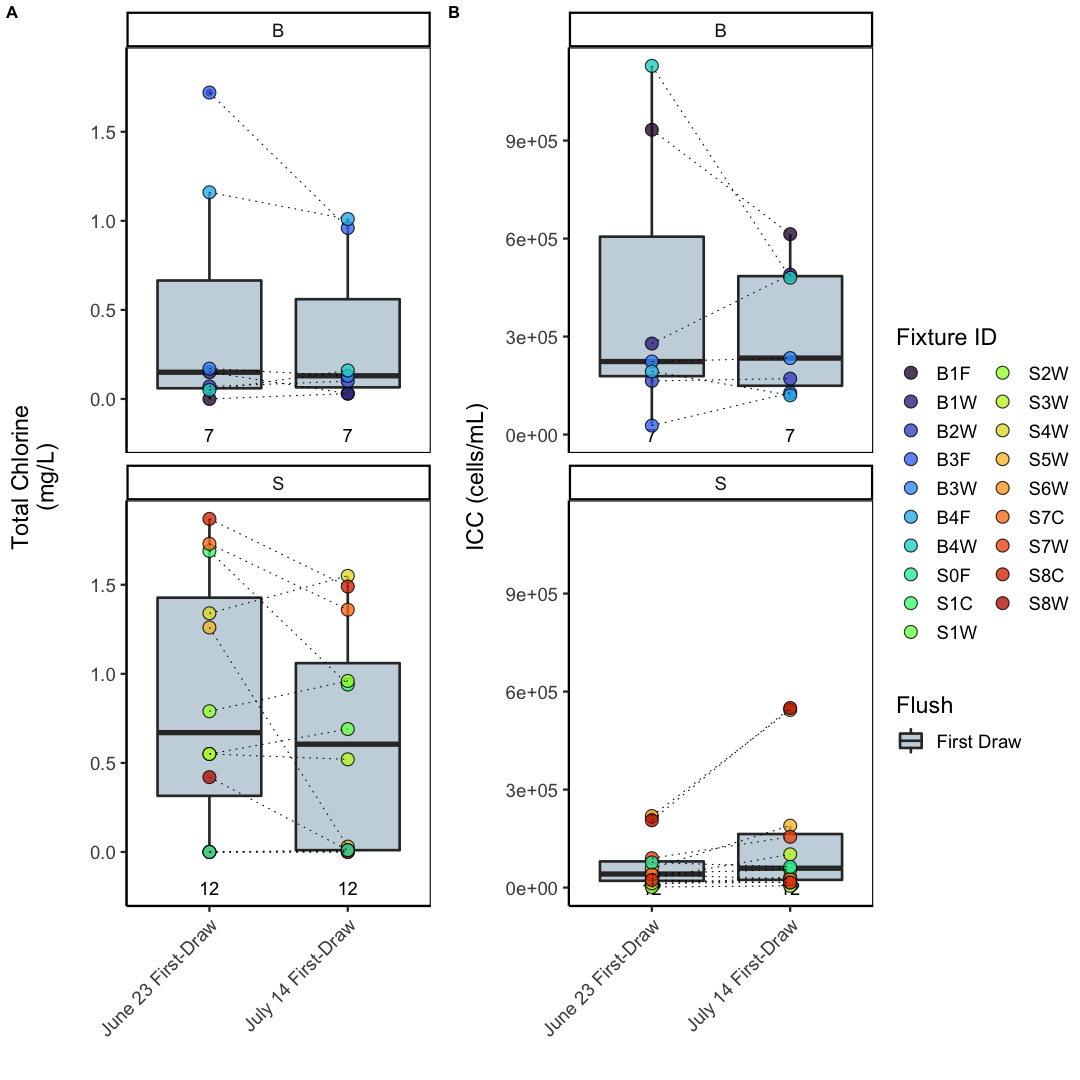

In [281]:
options(repr.plot.width = 9, repr.plot.height = 9)
ggarrange(dorm_cl, dorm_ICC, labels= c("A", "B"), font.label = list(size = 10, color = "black", face = "bold", family = NULL), legend = "right", common.legend = T, align = c("hv"))
ggsave(paste0(fig_dir, 'FigureS5.jpeg'), width=9, height=9)


In [282]:
#dorm cells not different over time
wilcox.test(a$value[(a$building== "B") & (a$date_cat== "6/23_pre")], a$value[(a$building== "B") & (a$date_cat== "7/14_pre")], conf.level= 0.95)
wilcox.test(a$value[(a$building== "S") & (a$date_cat== "6/23_pre")], a$value[(a$building== "S") & (a$date_cat== "7/14_pre")], conf.level= 0.95)



	Wilcoxon rank sum exact test

data:  a$value[(a$building == "B") & (a$date_cat == "6/23_pre")] and a$value[(a$building == "B") & (a$date_cat == "7/14_pre")]
W = 26, p-value = 0.9015
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  a$value[(a$building == "S") & (a$date_cat == "6/23_pre")] and a$value[(a$building == "S") & (a$date_cat == "7/14_pre")]
W = 59, p-value = 0.4776
alternative hypothesis: true location shift is not equal to 0


Warning message:
“Removed 1 rows containing non-finite values (new_stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (new_stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


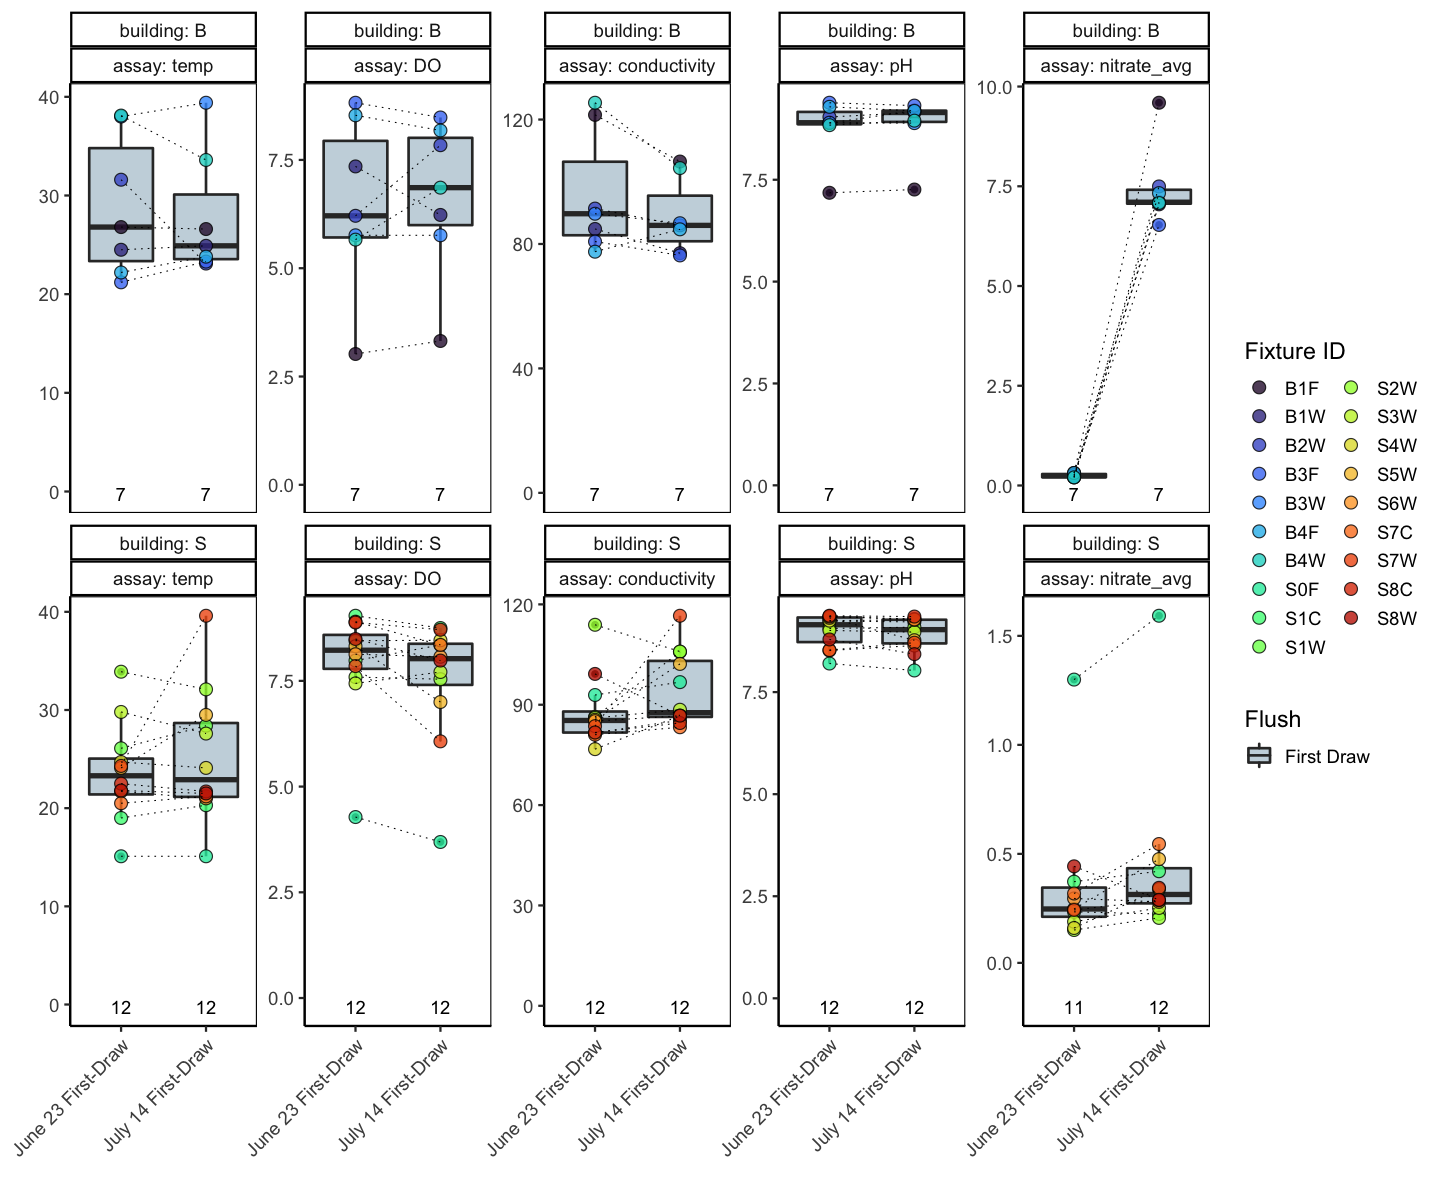

In [283]:
#plot dorm values throughout study

options(repr.plot.width = 12, repr.plot.height = 10)
a<- data_all_melt %>% drop_na(date_cat) %>% filter(assay== "DO" |assay== "nitrate_avg" |assay== "conductivity" |assay== "temp"|assay== "pH" ) %>% 
filter(building == "S" | building == "B") %>% filter(tap_code != "DMain")

Fig7 <- ggplot(a, aes(x=date_formal, y=value))+
geom_boxplot(lwd=0.75, aes(fill=flush))+
scale_fill_viridis_d(begin = 0.35, end = 0.8, option = "D", alpha=0.3, labels=c("First Draw", "Flushed", "Day After Flush"), name= "Flush")+
    ggnewscale::new_scale_fill()+
stat_summary(fun.data = give.n, geom = "text", position = position_dodge(width = 0.75))+
geom_point(aes(fill= tap_code), shape=21, color="black", size=3.3, alpha=0.8)+
# scale_fill_viridis_d(option="G")+
scale_fill_viridis_d(begin = 0, end = 0.9, name= "Fixture ID", alpha=0.8, option = "H")+
# scale_fill_manual(values=as.vector(polychrome(28)), guide="none")+
geom_line(aes(group=tap_code), size=0.3, linetype="dotted")+
xlab('')+
ylab('')+
facet_wrap(building~assay, nrow=2,scale= "free_y", labeller= label_both  )+
guides(fill=guide_legend(ncol = 2))+
theme(axis.text.x = element_text(angle = 45, hjust=1))+
theme(legend.position= "right", 
      panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
Fig7

ggsave(paste0(fig_dir, 'FigureS15.jpeg'), width=12, height=10)